In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from time import time

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
import torch.optim as optim

In [3]:
torch.__version__

'0.4.0'

In [4]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [5]:
device = torch.device('cuda' if USE_CUDA else 'cpu')

In [6]:
from torchvision.datasets import MNIST, CIFAR10
from torchvision import transforms
from torch.utils.data import TensorDataset, DataLoader

In [7]:
batch_size = 100

In [8]:
kwargs = {'num_workers': 1, 'pin_memory': True} if USE_CUDA else {}

dataset = CIFAR10

train_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=True, download=True, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

test_loader = torch.utils.data.DataLoader(
    dataset(
        './data', train=False, transform=transforms.ToTensor()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

Files already downloaded and verified


In [9]:
print(train_loader.dataset.train_data.shape)
print(test_loader.dataset.test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [10]:
from sklearn.model_selection import train_test_split

train_dataset_labelled, train_dataset_unlabelled, train_labels_labelled, train_labels_unlabelled = train_test_split(
    train_loader.dataset.train_data, np.array(train_loader.dataset.train_labels), train_size=4000
)
train_dataset_labelled.shape, train_dataset_unlabelled.shape, train_labels_labelled.shape, train_labels_unlabelled.shape

/home/golikov/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


((4000, 32, 32, 3), (46000, 32, 32, 3), (4000,), (46000,))

In [11]:
np.sum(np.array(train_loader.dataset.train_labels) == 0) / np.array(train_loader.dataset.train_labels).shape[0]

0.10000000000000001

In [12]:
np.max(train_dataset_labelled)

255

In [13]:
train_loader_labelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_labelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_labelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)
train_loader_unlabelled = DataLoader(
    TensorDataset(
        torch.from_numpy(np.transpose(train_dataset_unlabelled, (0,3,1,2))).float() / 255, 
        torch.Tensor(train_labels_unlabelled).long()
    ),
    batch_size=batch_size, shuffle=True, **kwargs
)

In [14]:
input_shape = train_loader.dataset.train_data.shape[1:]
input_shape = input_shape[-1:] + input_shape[:-1]
output_size = 10

**CAE**

In [15]:
class ReshapeLayer(nn.Module):
    def __init__(self, *args):
        super(ReshapeLayer, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)

In [16]:
class GeneratorConditioned(nn.Module):
    def __init__(self, input_shape, output_dim=512, noise_magnitude=0.0):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2] # [3 x 32 x 32]
        self.noise_magnitude = noise_magnitude

        self.image_processor = nn.Sequential(
            nn.Conv2d(input_shape[0], 128, 4, padding=2, stride=2), # [128 x 17 x 17]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, 5, padding=2, stride=2), # [256 x 9 x 9]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, 5, padding=2, stride=2), # [512 x 5 x 5]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 5, padding=2, stride=2), # [1024 x 3 x 3]
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            ReshapeLayer(1024 * 3 * 3),
            nn.Linear(1024 * 3 * 3, output_dim) # [output_dim]
        )

    def forward(self, X, Z=None):
        if Z is None:
            Z = torch.normal(mean=torch.zeros_like(X)) * self.noise_magnitude
        return self.image_processor(X + Z)

In [17]:
class CAE(nn.Module):
    def __init__(self, input_shape, latent_dim):

        super(type(self), self).__init__()
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        
        self.proposal_generator = GeneratorConditioned(input_shape, output_dim=latent_dim)
        
        self.generative_network = nn.Sequential(
            nn.Linear(latent_dim, 1024 * 4 * 4),
            ReshapeLayer(1024, 4, 4), # [1024 x 4 x 4]
            nn.ConvTranspose2d(1024, 512, 5, padding=1, stride=2), # [512 x 9 x 9]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 5, padding=2, stride=2), # [256 x 17 x 17]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, padding=2, stride=2), # [128 x 32 x 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 3, 1), # [3 x 32 x 32]
            #nn.Sigmoid()
        )

    def sample_latent(self, X):
        return self.proposal_generator(X)

    def generative_distr(self, z):
        return self.generative_network(z)

    def batch_loss(self, X, return_reconstruction_loss=True, return_contraction_loss=True): 
        n = X.shape[0]
        if return_contraction_loss:
            X.requires_grad_()
            Z = self.sample_latent(X)
            k = np.random.choice(self.latent_dim)
            jacobian_k = autograd.grad([torch.sum(Z[:, k])], [X], create_graph=True)[0]
            contractive_loss = torch.sum(jacobian_k ** 2) / n
        else:
            Z = self.sample_latent(X)
            contractive_loss = None
        if return_reconstruction_loss:
            X_rec = self.generative_distr(Z)
            reconstruction_loss = torch.sum((X_rec - X) ** 2) / n
            #reconstruction_loss = torch.sum(torch.abs(X_rec - X)) / n
            #reconstruction_loss = torch.sum(binary_crossentropy_loss(X.view(n, -1), X_rec.view(n, -1))) / n
        else:
            reconstruction_loss = None
        return reconstruction_loss, contractive_loss


In [18]:
def show_images(x):
    plt.figure(figsize=(12, 12 / 10 * (x.shape[0] // 10 + 1)))
    for i in range(x.shape[0]):
        plt.subplot(x.shape[0] // 10 + 1, 10, i + 1)
        plt.imshow(np.transpose(x.data[i].to(torch.device('cpu')).numpy(), axes=(1,2,0)), cmap='Greys_r', vmin=0, vmax=1, interpolation='lanczos')
        plt.axis('off')

Epoch 1 of 50 took 100.77s;
train reconstruction loss: 14.09; test reconstruction loss: 27.41
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 2 of 50 took 100.96s;
train reconstruction loss: 14.04; test reconstruction loss: 27.44
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 3 of 50 took 100.95s;
train reconstruction loss: 13.99; test reconstruction loss: 27.48
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 4 of 50 took 100.96s;
train reconstruction loss: 13.94; test reconstruction loss: 27.44
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 5 of 50 took 100.86s;
train reconstruction loss: 13.91; test reconstruction loss: 27.57
train contraction loss: 0.02; test contraction loss: 0.00



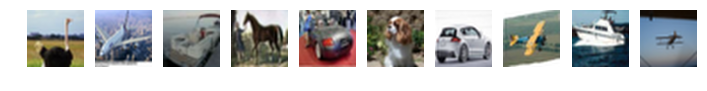

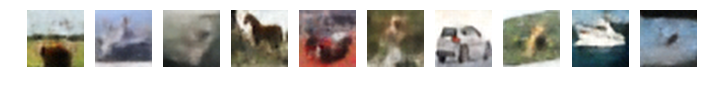

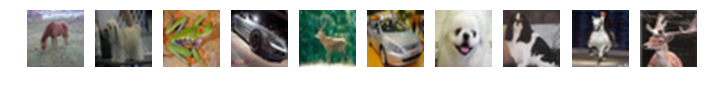

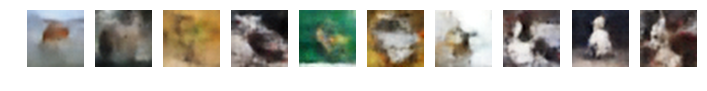

Epoch 6 of 50 took 100.74s;
train reconstruction loss: 13.88; test reconstruction loss: 27.64
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 7 of 50 took 100.43s;
train reconstruction loss: 13.88; test reconstruction loss: 27.51
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 8 of 50 took 100.22s;
train reconstruction loss: 13.85; test reconstruction loss: 27.62
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 9 of 50 took 100.55s;
train reconstruction loss: 13.78; test reconstruction loss: 27.70
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 10 of 50 took 100.73s;
train reconstruction loss: 13.75; test reconstruction loss: 27.72
train contraction loss: 0.02; test contraction loss: 0.00



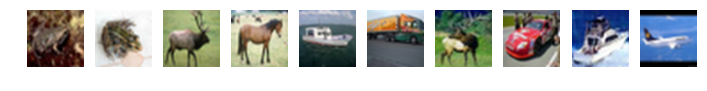

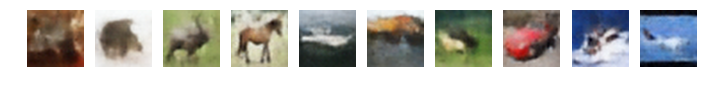

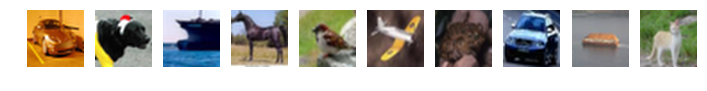

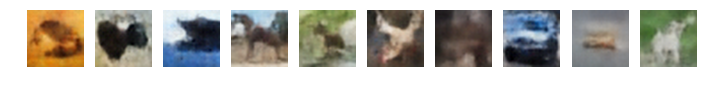

Epoch 11 of 50 took 100.71s;
train reconstruction loss: 13.71; test reconstruction loss: 27.75
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 12 of 50 took 100.75s;
train reconstruction loss: 13.71; test reconstruction loss: 27.64
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 13 of 50 took 100.71s;
train reconstruction loss: 13.67; test reconstruction loss: 27.97
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 14 of 50 took 100.74s;
train reconstruction loss: 13.65; test reconstruction loss: 27.69
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 15 of 50 took 100.71s;
train reconstruction loss: 13.61; test reconstruction loss: 28.12
train contraction loss: 0.02; test contraction loss: 0.00



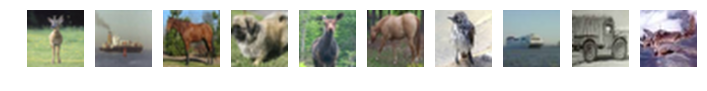

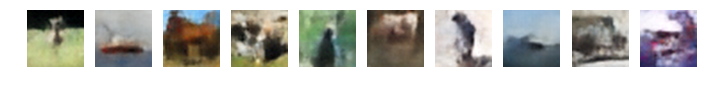

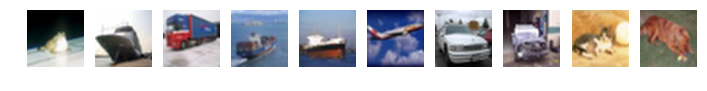

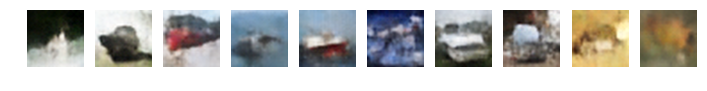

Epoch 16 of 50 took 100.72s;
train reconstruction loss: 13.59; test reconstruction loss: 27.65
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 17 of 50 took 100.73s;
train reconstruction loss: 13.58; test reconstruction loss: 28.06
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 18 of 50 took 100.77s;
train reconstruction loss: 13.55; test reconstruction loss: 27.73
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 19 of 50 took 100.75s;
train reconstruction loss: 13.52; test reconstruction loss: 27.96
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 20 of 50 took 100.72s;
train reconstruction loss: 13.51; test reconstruction loss: 28.04
train contraction loss: 0.02; test contraction loss: 0.00



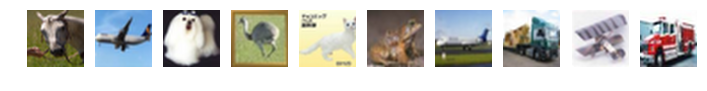

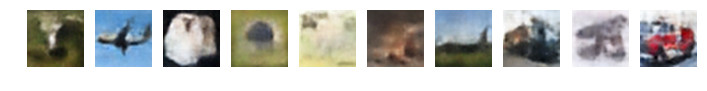

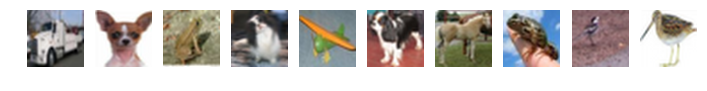

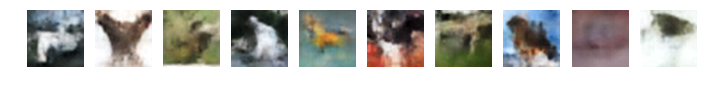

Epoch 21 of 50 took 100.72s;
train reconstruction loss: 13.50; test reconstruction loss: 28.20
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 22 of 50 took 100.73s;
train reconstruction loss: 13.46; test reconstruction loss: 27.96
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 23 of 50 took 100.76s;
train reconstruction loss: 13.43; test reconstruction loss: 27.95
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 24 of 50 took 100.72s;
train reconstruction loss: 13.43; test reconstruction loss: 28.15
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 25 of 50 took 100.75s;
train reconstruction loss: 13.37; test reconstruction loss: 28.09
train contraction loss: 0.02; test contraction loss: 0.00



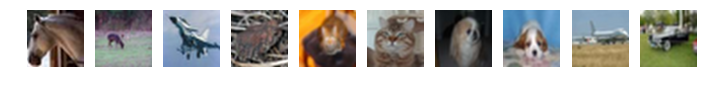

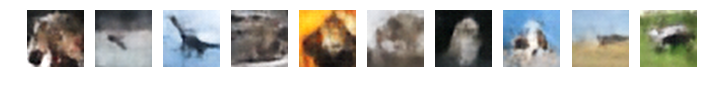

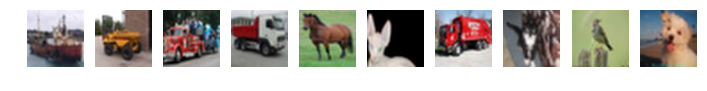

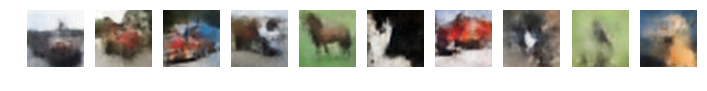

Epoch 26 of 50 took 100.73s;
train reconstruction loss: 13.34; test reconstruction loss: 28.28
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 27 of 50 took 100.78s;
train reconstruction loss: 13.34; test reconstruction loss: 28.10
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 28 of 50 took 100.78s;
train reconstruction loss: 13.29; test reconstruction loss: 28.02
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 29 of 50 took 100.87s;
train reconstruction loss: 13.29; test reconstruction loss: 28.32
train contraction loss: 0.02; test contraction loss: 0.00

Epoch 30 of 50 took 100.86s;
train reconstruction loss: 13.27; test reconstruction loss: 28.45
train contraction loss: 0.02; test contraction loss: 0.00



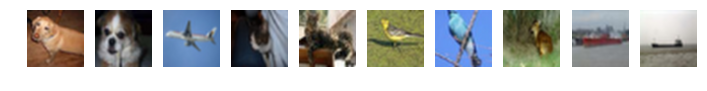

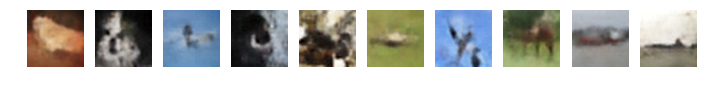

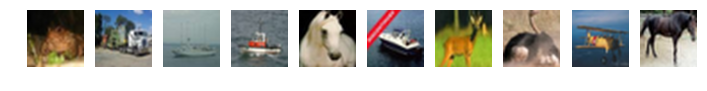

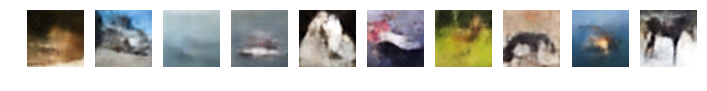

Process Process-186:
Traceback (most recent call last):
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/golikov/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/golikov/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [20]:
latent_dim = 64

num_epochs = 50
save_every = 10

name_prefix = 'cae_results/'

#try:
if True:
    #vae = cuda_wrapper(VAE(latent_dim, input_shape))
    #vae.load_state_dict(torch.load(name_prefix + 'vae.pt'))
    #print("Found pretrained VAE")
#except:
    #print("Didn't found pretrained VAE; training...")
    
    #cae = CAE(input_shape, latent_dim).to(device)
    #optimizer = optim.Adam(cae.parameters(), lr=3e-4, betas=(0.5, 0.999))

    #scheduler = optim.lr_scheduler.LambdaLR(
    #    optimizer, lambda n: 1 if n < 30 else 0.5 if n < 50 else 0.1 if n < 100 else 0.01
    #)

    for epoch in range(num_epochs):
        start_time = time()
        
        scheduler.step()
        
        regularization_factor = 10

        cum_loss_reconstruction = 0
        cum_loss_contraction = 0
        batch_count = 0
        
        for X_batch, _ in train_loader:
            X_batch = X_batch.to(device)

            loss_reconstruction, loss_contraction = cae.batch_loss(X_batch)
            cum_loss_reconstruction += loss_reconstruction.item()
            cum_loss_contraction += loss_contraction.item()
                
            optimizer.zero_grad()
            (loss_reconstruction + loss_contraction * regularization_factor).backward()
            optimizer.step()
            batch_count += 1
    
        mean_train_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_train_loss_contraction = cum_loss_contraction / batch_count

        cum_loss_reconstruction = 0
        cum_loss_contraction = 0
        batch_count = 0
        
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)

                loss_reconstruction, _ = cae.batch_loss(X_batch, return_contraction_loss=False)
                cum_loss_reconstruction += loss_reconstruction.item()
                #cum_loss_contraction += loss_contraction.item()
        
                batch_count += 1
            
        mean_test_loss_reconstruction = cum_loss_reconstruction / batch_count
        mean_test_loss_contraction = cum_loss_contraction / batch_count

        print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
        print('train reconstruction loss: {:.2f}; test reconstruction loss: {:.2f}'.format(
            mean_train_loss_reconstruction, mean_test_loss_reconstruction
        ))
        print('train contraction loss: {:.2f}; test contraction loss: {:.2f}'.format(
            mean_train_loss_contraction, mean_test_loss_contraction
        ))
        print()
        
        if (epoch+1) % 5 == 0:
            X_batch = next(iter(train_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                cae.generative_network(
                    cae.proposal_generator(X_batch)
                )
            )
            plt.show()
            X_batch = next(iter(test_loader))[0][:10].to(device)
            show_images(X_batch)
            plt.show()
            show_images(
                cae.generative_network(
                    cae.proposal_generator(X_batch)
                )
            )
            plt.show()
    
        if (epoch+1) % save_every == 0:
            torch.save(cae.state_dict(), name_prefix + 'cae.pt')
        


**Tangent prop**

In [21]:
def constrain_loss_function(model, generative_model, batch_gen=None, reparam_invariant=True, use_all_classes=False):
    latent_dim = generative_model.latent_dim
    
    if reparam_invariant:
        if batch_gen is None:
            z_gen = torch.normal(std=torch.ones(batch_size, latent_dim, device=device)) # [batch_size x latent_dim]
            X_gen = generative_model.generative_distr(z_gen).detach().requires_grad_() # [batch_size x C x H x W]
        else:
            X_gen, _ = next(batch_gen)
            X_gen = X_gen.to(device).requires_grad_()
        z_inferred = generative_model.sample_latent(X_gen) # [batch_size x latent_dim]
    else:
        if batch_gen is None:
            z_inferred = torch.normal(
                std=torch.ones(batch_size, latent_dim, device=device)
            ).requires_grad_() # [batch_size x latent_dim]
        else:
            X, _ = next(batch_gen)
            X = X.to(device)
            z_inferred = generative_model.sample_latent(X).detach().requires_grad_() # [batch_size x latent_dim]
    X_inferred = generative_model.generative_distr(z_inferred) # [batch_size x C x H x W]
    model_output = model(X_inferred) # [batch_size x num_classes]
    
    if use_all_classes:
        grad_output_wrt_input_for_each_class = []
        for output in torch.unbind(torch.sum(model_output, dim=0)):
            grad_output_wrt_input_for_each_class.append(
                autograd.grad([output], [X_gen if reparam_invariant else z_inferred], create_graph=True)[0]
            ) # [batch_size x latent_dim]
        grad_output_wrt_input = torch.stack(
            grad_output_wrt_input_for_each_class
        ) # [num_classes x batch_size x latent_dim]
        return torch.sum(grad_output_wrt_input ** 2) / batch_size
    else:
        y = np.random.choice(output_size)
        output = torch.sum(model_output, dim=0)[y]
        grad_output_wrt_input = autograd.grad(
            [output], [X_gen if reparam_invariant else z_inferred], create_graph=True
        )[0]
        return output_size * torch.sum(grad_output_wrt_input ** 2) / batch_size

**Training**

In [22]:
class ModelConvolutional(nn.Module):
    def __init__(
        self, input_shape, output_size 
    ):
        super(type(self), self).__init__()
        assert input_shape[1] == input_shape[2]
        self.layers = nn.ModuleList([
            nn.Dropout(p=0.2),
            nn.Conv2d(input_shape[0], 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(96, 96, 3, padding=1),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(96),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(96, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 3, padding=1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(192),
            
            nn.Dropout(p=0.5),
            nn.Conv2d(192, 192, 3),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(192, 192, 1),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(negative_slope=0.2),
            nn.AvgPool2d(6)
        ])
        self.output_layer = nn.utils.weight_norm(nn.Linear(192, 10))
        
    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        X = X.view(X.shape[0], -1)
        return F.log_softmax(self.output_layer(X), dim=1)

In [23]:
train_losses = {}
train_accs = {}

test_losses = {}
test_accs = {}

In [ ]:
num_epochs = 200
num_runs = 5
save_every = 10

modes = ['stochastic_manifold_reg_on_train_data__eta=' + str(eta) for eta in [0, 1e-5, 1e-4, 1e-3, 1e-2]]

loss_function = nn.NLLLoss()

for mode in modes:
    mode_name = mode + '__labelled=4000__epochs=' + str(num_epochs)
    eta = float(mode.split('=')[1])

    print('Mode:', mode)
    print(mode_name)
    print('eta =', eta)
    print()
    
    train_losses[mode] = []
    train_accs[mode] = []
    
    test_losses[mode] = []
    test_accs[mode] = []

    torch.manual_seed(123)
    np.random.seed(123)
    for run in range(num_runs):
        print('run', run+1)
        
        train_losses[mode].append([])
        train_accs[mode].append([])
    
        test_losses[mode].append([])
        test_accs[mode].append([])

        model = ModelConvolutional(input_shape, output_size).to(device)
        optimizer = optim.Adam(model.parameters(), lr=3e-4, betas=(0.5, 0.999))
        #scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda k: ((num_epochs-k)/200 if k >= num_epochs-200 else 1))
    
        for epoch in range(num_epochs):
            start_time = time()
    
            #scheduler.step()
    
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_loss_full = 0
            cum_acc = 0
            batch_count = 0

            model.train()
            train_iter_unlabelled = iter(train_loader_unlabelled)
            for X, y in train_loader_labelled:
                X, y = X.to(device), y.to(device)
                prediction = model(X)
                loss_data = loss_function(prediction, y)
                cum_loss_data += loss_data.item()
        
                loss_constrain = constrain_loss_function(
                    model, cae, reparam_invariant=True, use_all_classes=False, batch_gen=train_iter_unlabelled
                )
                cum_loss_constrain += loss_constrain.item()
        
                loss_full = loss_data + eta * loss_constrain
                cum_loss_full += loss_full.item()
            
                acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                cum_acc += acc.item()
        
                optimizer.zero_grad()
                loss_full.backward()
                optimizer.step()
                batch_count += 1
            
            mean_train_loss_data = cum_loss_data / batch_count
            mean_train_loss_constrain = cum_loss_constrain / batch_count
            mean_train_loss_full = cum_loss_full / batch_count
            mean_train_acc = cum_acc / batch_count

            train_losses[mode][-1].append(mean_train_loss_data)
            train_accs[mode][-1].append(mean_train_acc)
        
            cum_loss_data = 0
            cum_loss_constrain = 0
            cum_acc = 0
            batch_count = 0

            model.eval()
            with torch.no_grad():
                for X, y in test_loader:
                    X, y = X.to(device), y.to(device)
                    prediction = model(X)
                    loss_data = loss_function(prediction, y)
                    cum_loss_data += loss_data.item()
        
                    acc = torch.mean((torch.max(prediction, dim=-1)[1] == y).float())
                    cum_acc += acc.item()
        
                    batch_count += 1
            
            mean_test_loss_data = cum_loss_data / batch_count
            mean_test_loss_constrain = cum_loss_constrain / batch_count
            mean_test_acc = cum_acc / batch_count

            test_losses[mode][-1].append(mean_test_loss_data)
            test_accs[mode][-1].append(mean_test_acc)
        
            print('Epoch {} of {} took {:.2f}s;'.format(epoch+1, num_epochs, time() - start_time))
            print('train loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}, full: {:.2f}'.format(
                    mean_train_loss_data, mean_train_loss_constrain, mean_train_loss_full
                )
            )
            print('train acc: {:.2f}'.format(mean_train_acc*100))
            print('test loss:')
            print(
                'data term: {:.2f}, constrain term: {:.2f}'.format(
                    mean_test_loss_data, mean_test_loss_constrain
                )
            )
            print('test acc: {:.2f}'.format(mean_test_acc*100))
            print()
        
            if (epoch+1) % save_every == 0:
                with open(name_prefix + mode_name + '/train_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(train_losses[mode]), f)
                with open(name_prefix + mode_name + '/test_losses.pkl', 'wb') as f:
                    pickle.dump(np.array(test_losses[mode]), f)
                with open(name_prefix + mode_name + '/train_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(train_accs[mode]), f)
                with open(name_prefix + mode_name + '/test_accs.pkl', 'wb') as f:
                    pickle.dump(np.array(test_accs[mode]), f)

                torch.save(model.state_dict(), name_prefix + mode_name + '/model.pt')

    train_losses[mode] = np.array(train_losses[mode])
    test_losses[mode] = np.array(test_losses[mode])
    train_accs[mode] = np.array(train_accs[mode])
    test_accs[mode] = np.array(test_accs[mode])
    

Mode: stochastic_manifold_reg_on_train_data__eta=0
stochastic_manifold_reg_on_train_data__eta=0__labelled=4000__epochs=200
eta = 0.0

run 1
Epoch 1 of 200 took 24.05s;
train loss:
data term: 2.03, constrain term: 0.03, full: 2.03
train acc: 25.10
test loss:
data term: 2.11, constrain term: 0.00
test acc: 21.74

Epoch 2 of 200 took 24.03s;
train loss:
data term: 1.82, constrain term: 0.14, full: 1.82
train acc: 35.45
test loss:
data term: 2.18, constrain term: 0.00
test acc: 21.57

Epoch 3 of 200 took 24.05s;
train loss:
data term: 1.71, constrain term: 0.35, full: 1.71
train acc: 38.37
test loss:
data term: 2.01, constrain term: 0.00
test acc: 23.85

Epoch 4 of 200 took 24.08s;
train loss:
data term: 1.64, constrain term: 0.55, full: 1.64
train acc: 41.10
test loss:
data term: 1.88, constrain term: 0.00
test acc: 29.38

Epoch 5 of 200 took 24.07s;
train loss:
data term: 1.58, constrain term: 0.81, full: 1.58
train acc: 42.75
test loss:
data term: 1.97, constrain term: 0.00
test acc: 28

Epoch 48 of 200 took 24.07s;
train loss:
data term: 0.53, constrain term: 43.93, full: 0.53
train acc: 83.07
test loss:
data term: 1.28, constrain term: 0.00
test acc: 57.58

Epoch 49 of 200 took 24.08s;
train loss:
data term: 0.50, constrain term: 45.40, full: 0.50
train acc: 83.85
test loss:
data term: 1.20, constrain term: 0.00
test acc: 59.46

Epoch 50 of 200 took 24.06s;
train loss:
data term: 0.49, constrain term: 45.64, full: 0.49
train acc: 84.62
test loss:
data term: 1.48, constrain term: 0.00
test acc: 54.62

Epoch 51 of 200 took 24.19s;
train loss:
data term: 0.48, constrain term: 47.71, full: 0.48
train acc: 84.63
test loss:
data term: 1.17, constrain term: 0.00
test acc: 61.58

Epoch 52 of 200 took 24.06s;
train loss:
data term: 0.46, constrain term: 50.48, full: 0.46
train acc: 85.82
test loss:
data term: 1.07, constrain term: 0.00
test acc: 64.04

Epoch 53 of 200 took 24.05s;
train loss:
data term: 0.43, constrain term: 54.28, full: 0.43
train acc: 86.67
test loss:
data 

Epoch 95 of 200 took 24.27s;
train loss:
data term: 0.11, constrain term: 179.80, full: 0.11
train acc: 97.73
test loss:
data term: 1.26, constrain term: 0.00
test acc: 65.79

Epoch 96 of 200 took 24.12s;
train loss:
data term: 0.12, constrain term: 181.87, full: 0.12
train acc: 97.23
test loss:
data term: 1.37, constrain term: 0.00
test acc: 63.06

Epoch 97 of 200 took 24.15s;
train loss:
data term: 0.12, constrain term: 180.25, full: 0.12
train acc: 96.60
test loss:
data term: 1.21, constrain term: 0.00
test acc: 66.90

Epoch 98 of 200 took 24.09s;
train loss:
data term: 0.12, constrain term: 188.33, full: 0.12
train acc: 96.85
test loss:
data term: 1.25, constrain term: 0.00
test acc: 64.95

Epoch 99 of 200 took 24.07s;
train loss:
data term: 0.11, constrain term: 189.18, full: 0.11
train acc: 97.05
test loss:
data term: 1.35, constrain term: 0.00
test acc: 64.93

Epoch 100 of 200 took 24.09s;
train loss:
data term: 0.10, constrain term: 195.30, full: 0.10
train acc: 97.70
test loss

Epoch 142 of 200 took 24.09s;
train loss:
data term: 0.06, constrain term: 306.81, full: 0.06
train acc: 98.48
test loss:
data term: 1.42, constrain term: 0.00
test acc: 66.01

Epoch 143 of 200 took 24.07s;
train loss:
data term: 0.05, constrain term: 316.27, full: 0.05
train acc: 98.65
test loss:
data term: 1.51, constrain term: 0.00
test acc: 64.98

Epoch 144 of 200 took 24.07s;
train loss:
data term: 0.05, constrain term: 314.16, full: 0.05
train acc: 98.88
test loss:
data term: 1.32, constrain term: 0.00
test acc: 67.20

Epoch 145 of 200 took 24.11s;
train loss:
data term: 0.05, constrain term: 315.86, full: 0.05
train acc: 98.73
test loss:
data term: 1.34, constrain term: 0.00
test acc: 66.67

Epoch 146 of 200 took 24.12s;
train loss:
data term: 0.05, constrain term: 323.34, full: 0.05
train acc: 98.83
test loss:
data term: 1.26, constrain term: 0.00
test acc: 68.28

Epoch 147 of 200 took 24.14s;
train loss:
data term: 0.04, constrain term: 315.06, full: 0.04
train acc: 99.08
test

Epoch 189 of 200 took 24.09s;
train loss:
data term: 0.04, constrain term: 405.09, full: 0.04
train acc: 98.93
test loss:
data term: 1.53, constrain term: 0.00
test acc: 66.10

Epoch 190 of 200 took 24.09s;
train loss:
data term: 0.05, constrain term: 417.39, full: 0.05
train acc: 98.58
test loss:
data term: 1.44, constrain term: 0.00
test acc: 66.98

Epoch 191 of 200 took 24.20s;
train loss:
data term: 0.03, constrain term: 421.26, full: 0.03
train acc: 99.25
test loss:
data term: 1.51, constrain term: 0.00
test acc: 66.24

Epoch 192 of 200 took 24.09s;
train loss:
data term: 0.04, constrain term: 419.93, full: 0.04
train acc: 99.10
test loss:
data term: 1.54, constrain term: 0.00
test acc: 65.80

Epoch 193 of 200 took 24.10s;
train loss:
data term: 0.03, constrain term: 426.06, full: 0.03
train acc: 99.43
test loss:
data term: 1.55, constrain term: 0.00
test acc: 65.96

Epoch 194 of 200 took 24.10s;
train loss:
data term: 0.05, constrain term: 425.77, full: 0.05
train acc: 98.60
test

Epoch 36 of 200 took 24.11s;
train loss:
data term: 0.74, constrain term: 21.88, full: 0.74
train acc: 75.25
test loss:
data term: 1.19, constrain term: 0.00
test acc: 59.11

Epoch 37 of 200 took 24.11s;
train loss:
data term: 0.70, constrain term: 24.37, full: 0.70
train acc: 77.37
test loss:
data term: 1.28, constrain term: 0.00
test acc: 56.27

Epoch 38 of 200 took 24.09s;
train loss:
data term: 0.69, constrain term: 25.32, full: 0.69
train acc: 77.80
test loss:
data term: 1.34, constrain term: 0.00
test acc: 55.79

Epoch 39 of 200 took 24.10s;
train loss:
data term: 0.66, constrain term: 26.98, full: 0.66
train acc: 78.57
test loss:
data term: 1.31, constrain term: 0.00
test acc: 56.62

Epoch 40 of 200 took 24.12s;
train loss:
data term: 0.66, constrain term: 28.52, full: 0.66
train acc: 78.45
test loss:
data term: 1.29, constrain term: 0.00
test acc: 57.16

Epoch 41 of 200 took 24.31s;
train loss:
data term: 0.63, constrain term: 31.15, full: 0.63
train acc: 79.20
test loss:
data 

Epoch 83 of 200 took 24.12s;
train loss:
data term: 0.15, constrain term: 142.88, full: 0.15
train acc: 96.33
test loss:
data term: 1.20, constrain term: 0.00
test acc: 65.81

Epoch 84 of 200 took 24.13s;
train loss:
data term: 0.16, constrain term: 144.63, full: 0.16
train acc: 96.05
test loss:
data term: 1.12, constrain term: 0.00
test acc: 66.77

Epoch 85 of 200 took 24.16s;
train loss:
data term: 0.13, constrain term: 150.97, full: 0.13
train acc: 96.75
test loss:
data term: 1.18, constrain term: 0.00
test acc: 66.37

Epoch 86 of 200 took 24.11s;
train loss:
data term: 0.15, constrain term: 155.79, full: 0.15
train acc: 95.73
test loss:
data term: 1.17, constrain term: 0.00
test acc: 66.36

Epoch 87 of 200 took 24.12s;
train loss:
data term: 0.13, constrain term: 153.90, full: 0.13
train acc: 97.20
test loss:
data term: 1.20, constrain term: 0.00
test acc: 65.93

Epoch 88 of 200 took 24.11s;
train loss:
data term: 0.14, constrain term: 155.29, full: 0.14
train acc: 96.55
test loss:

Epoch 130 of 200 took 24.27s;
train loss:
data term: 0.07, constrain term: 262.78, full: 0.07
train acc: 97.75
test loss:
data term: 1.24, constrain term: 0.00
test acc: 68.87

Epoch 131 of 200 took 24.18s;
train loss:
data term: 0.05, constrain term: 279.72, full: 0.05
train acc: 99.25
test loss:
data term: 1.18, constrain term: 0.00
test acc: 69.88

Epoch 132 of 200 took 24.14s;
train loss:
data term: 0.05, constrain term: 282.03, full: 0.05
train acc: 98.73
test loss:
data term: 1.27, constrain term: 0.00
test acc: 68.32

Epoch 133 of 200 took 24.14s;
train loss:
data term: 0.06, constrain term: 280.13, full: 0.06
train acc: 98.78
test loss:
data term: 1.23, constrain term: 0.00
test acc: 68.83

Epoch 134 of 200 took 24.18s;
train loss:
data term: 0.05, constrain term: 288.14, full: 0.05
train acc: 98.90
test loss:
data term: 1.21, constrain term: 0.00
test acc: 69.22

Epoch 135 of 200 took 24.15s;
train loss:
data term: 0.07, constrain term: 292.82, full: 0.07
train acc: 98.05
test

Epoch 177 of 200 took 24.12s;
train loss:
data term: 0.04, constrain term: 391.68, full: 0.04
train acc: 98.75
test loss:
data term: 1.40, constrain term: 0.00
test acc: 68.14

Epoch 178 of 200 took 24.29s;
train loss:
data term: 0.07, constrain term: 374.39, full: 0.07
train acc: 97.93
test loss:
data term: 1.42, constrain term: 0.00
test acc: 66.45

Epoch 179 of 200 took 24.14s;
train loss:
data term: 0.05, constrain term: 367.61, full: 0.05
train acc: 98.65
test loss:
data term: 1.32, constrain term: 0.00
test acc: 68.83

Epoch 180 of 200 took 24.08s;
train loss:
data term: 0.06, constrain term: 378.83, full: 0.06
train acc: 98.38
test loss:
data term: 1.38, constrain term: 0.00
test acc: 68.61

Epoch 181 of 200 took 24.19s;
train loss:
data term: 0.03, constrain term: 385.69, full: 0.03
train acc: 99.38
test loss:
data term: 1.35, constrain term: 0.00
test acc: 69.58

Epoch 182 of 200 took 24.38s;
train loss:
data term: 0.03, constrain term: 387.57, full: 0.03
train acc: 99.45
test

Epoch 24 of 200 took 24.07s;
train loss:
data term: 0.98, constrain term: 10.24, full: 0.98
train acc: 66.30
test loss:
data term: 1.21, constrain term: 0.00
test acc: 56.34

Epoch 25 of 200 took 24.14s;
train loss:
data term: 0.98, constrain term: 11.02, full: 0.98
train acc: 66.55
test loss:
data term: 1.39, constrain term: 0.00
test acc: 50.79

Epoch 26 of 200 took 24.07s;
train loss:
data term: 0.94, constrain term: 12.24, full: 0.94
train acc: 68.40
test loss:
data term: 1.22, constrain term: 0.00
test acc: 56.73

Epoch 27 of 200 took 24.08s;
train loss:
data term: 0.94, constrain term: 12.60, full: 0.94
train acc: 66.92
test loss:
data term: 1.30, constrain term: 0.00
test acc: 53.21

Epoch 28 of 200 took 24.08s;
train loss:
data term: 0.91, constrain term: 14.34, full: 0.91
train acc: 68.65
test loss:
data term: 1.28, constrain term: 0.00
test acc: 55.34

Epoch 29 of 200 took 24.08s;
train loss:
data term: 0.87, constrain term: 14.87, full: 0.87
train acc: 70.48
test loss:
data 

Epoch 71 of 200 took 24.40s;
train loss:
data term: 0.24, constrain term: 100.59, full: 0.24
train acc: 92.95
test loss:
data term: 1.23, constrain term: 0.00
test acc: 62.33

Epoch 72 of 200 took 24.22s;
train loss:
data term: 0.22, constrain term: 99.69, full: 0.22
train acc: 93.95
test loss:
data term: 1.12, constrain term: 0.00
test acc: 65.77

Epoch 73 of 200 took 24.20s;
train loss:
data term: 0.22, constrain term: 105.33, full: 0.22
train acc: 93.82
test loss:
data term: 1.32, constrain term: 0.00
test acc: 61.75

Epoch 74 of 200 took 24.30s;
train loss:
data term: 0.20, constrain term: 109.57, full: 0.20
train acc: 95.20
test loss:
data term: 1.15, constrain term: 0.00
test acc: 65.15

Epoch 75 of 200 took 24.28s;
train loss:
data term: 0.22, constrain term: 113.56, full: 0.22
train acc: 94.48
test loss:
data term: 1.20, constrain term: 0.00
test acc: 64.32

Epoch 76 of 200 took 24.29s;
train loss:
data term: 0.21, constrain term: 117.61, full: 0.21
train acc: 94.08
test loss:


Epoch 118 of 200 took 24.27s;
train loss:
data term: 0.09, constrain term: 230.05, full: 0.09
train acc: 97.73
test loss:
data term: 1.38, constrain term: 0.00
test acc: 64.47

Epoch 119 of 200 took 24.26s;
train loss:
data term: 0.07, constrain term: 238.65, full: 0.07
train acc: 98.48
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.22

Epoch 120 of 200 took 24.26s;
train loss:
data term: 0.09, constrain term: 238.65, full: 0.09
train acc: 97.63
test loss:
data term: 1.34, constrain term: 0.00
test acc: 66.79

Epoch 121 of 200 took 24.40s;
train loss:
data term: 0.08, constrain term: 242.07, full: 0.08
train acc: 98.03
test loss:
data term: 1.40, constrain term: 0.00
test acc: 65.66

Epoch 122 of 200 took 24.26s;
train loss:
data term: 0.07, constrain term: 247.74, full: 0.07
train acc: 98.23
test loss:
data term: 1.27, constrain term: 0.00
test acc: 67.04

Epoch 123 of 200 took 24.40s;
train loss:
data term: 0.07, constrain term: 257.57, full: 0.07
train acc: 98.33
test

Epoch 165 of 200 took 24.23s;
train loss:
data term: 0.04, constrain term: 348.70, full: 0.04
train acc: 98.80
test loss:
data term: 1.49, constrain term: 0.00
test acc: 65.66

Epoch 166 of 200 took 24.24s;
train loss:
data term: 0.05, constrain term: 338.22, full: 0.05
train acc: 98.78
test loss:
data term: 1.25, constrain term: 0.00
test acc: 68.86

Epoch 167 of 200 took 24.10s;
train loss:
data term: 0.04, constrain term: 357.91, full: 0.04
train acc: 98.88
test loss:
data term: 1.38, constrain term: 0.00
test acc: 67.60

Epoch 168 of 200 took 24.47s;
train loss:
data term: 0.05, constrain term: 358.42, full: 0.05
train acc: 98.68
test loss:
data term: 1.42, constrain term: 0.00
test acc: 67.63

Epoch 169 of 200 took 24.18s;
train loss:
data term: 0.06, constrain term: 361.15, full: 0.06
train acc: 98.40
test loss:
data term: 1.76, constrain term: 0.00
test acc: 62.68

Epoch 170 of 200 took 24.22s;
train loss:
data term: 0.06, constrain term: 347.58, full: 0.06
train acc: 98.40
test

Epoch 12 of 200 took 24.14s;
train loss:
data term: 1.30, constrain term: 3.07, full: 1.30
train acc: 53.57
test loss:
data term: 1.70, constrain term: 0.00
test acc: 38.33

Epoch 13 of 200 took 24.27s;
train loss:
data term: 1.29, constrain term: 3.47, full: 1.29
train acc: 56.07
test loss:
data term: 1.69, constrain term: 0.00
test acc: 36.79

Epoch 14 of 200 took 24.14s;
train loss:
data term: 1.25, constrain term: 3.98, full: 1.25
train acc: 56.18
test loss:
data term: 1.93, constrain term: 0.00
test acc: 37.29

Epoch 15 of 200 took 24.13s;
train loss:
data term: 1.22, constrain term: 4.71, full: 1.22
train acc: 57.43
test loss:
data term: 1.43, constrain term: 0.00
test acc: 46.76

Epoch 16 of 200 took 24.24s;
train loss:
data term: 1.19, constrain term: 4.92, full: 1.19
train acc: 59.35
test loss:
data term: 1.52, constrain term: 0.00
test acc: 43.89

Epoch 17 of 200 took 24.29s;
train loss:
data term: 1.16, constrain term: 6.05, full: 1.16
train acc: 58.85
test loss:
data term: 

Epoch 59 of 200 took 24.29s;
train loss:
data term: 0.35, constrain term: 68.94, full: 0.35
train acc: 90.25
test loss:
data term: 1.28, constrain term: 0.00
test acc: 61.07

Epoch 60 of 200 took 24.30s;
train loss:
data term: 0.37, constrain term: 69.45, full: 0.37
train acc: 89.12
test loss:
data term: 1.14, constrain term: 0.00
test acc: 64.10

Epoch 61 of 200 took 24.45s;
train loss:
data term: 0.34, constrain term: 73.06, full: 0.34
train acc: 90.53
test loss:
data term: 1.27, constrain term: 0.00
test acc: 60.71

Epoch 62 of 200 took 24.27s;
train loss:
data term: 0.33, constrain term: 76.15, full: 0.33
train acc: 90.35
test loss:
data term: 1.18, constrain term: 0.00
test acc: 63.81

Epoch 63 of 200 took 24.28s;
train loss:
data term: 0.31, constrain term: 78.60, full: 0.31
train acc: 91.53
test loss:
data term: 1.21, constrain term: 0.00
test acc: 61.92

Epoch 64 of 200 took 24.28s;
train loss:
data term: 0.31, constrain term: 84.01, full: 0.31
train acc: 91.13
test loss:
data 

Epoch 106 of 200 took 24.26s;
train loss:
data term: 0.12, constrain term: 204.66, full: 0.12
train acc: 96.73
test loss:
data term: 1.16, constrain term: 0.00
test acc: 67.43

Epoch 107 of 200 took 24.25s;
train loss:
data term: 0.10, constrain term: 205.91, full: 0.10
train acc: 97.38
test loss:
data term: 1.34, constrain term: 0.00
test acc: 65.06

Epoch 108 of 200 took 24.25s;
train loss:
data term: 0.09, constrain term: 212.34, full: 0.09
train acc: 97.83
test loss:
data term: 1.25, constrain term: 0.00
test acc: 66.29

Epoch 109 of 200 took 24.26s;
train loss:
data term: 0.08, constrain term: 215.61, full: 0.08
train acc: 98.23
test loss:
data term: 1.19, constrain term: 0.00
test acc: 67.39

Epoch 110 of 200 took 24.25s;
train loss:
data term: 0.08, constrain term: 225.43, full: 0.08
train acc: 97.93
test loss:
data term: 1.28, constrain term: 0.00
test acc: 66.61

Epoch 111 of 200 took 24.42s;
train loss:
data term: 0.08, constrain term: 220.64, full: 0.08
train acc: 98.38
test

Epoch 153 of 200 took 24.26s;
train loss:
data term: 0.07, constrain term: 330.12, full: 0.07
train acc: 98.23
test loss:
data term: 1.31, constrain term: 0.00
test acc: 68.68

Epoch 154 of 200 took 24.28s;
train loss:
data term: 0.06, constrain term: 325.57, full: 0.06
train acc: 98.43
test loss:
data term: 1.51, constrain term: 0.00
test acc: 66.03

Epoch 155 of 200 took 24.26s;
train loss:
data term: 0.05, constrain term: 334.10, full: 0.05
train acc: 98.68
test loss:
data term: 1.62, constrain term: 0.00
test acc: 64.94

Epoch 156 of 200 took 24.26s;
train loss:
data term: 0.04, constrain term: 333.89, full: 0.04
train acc: 99.10
test loss:
data term: 1.43, constrain term: 0.00
test acc: 66.61

Epoch 157 of 200 took 24.29s;
train loss:
data term: 0.05, constrain term: 354.86, full: 0.05
train acc: 98.83
test loss:
data term: 1.40, constrain term: 0.00
test acc: 66.80

Epoch 158 of 200 took 24.30s;
train loss:
data term: 0.05, constrain term: 341.47, full: 0.05
train acc: 98.55
test

Epoch 200 of 200 took 24.40s;
train loss:
data term: 0.05, constrain term: 426.50, full: 0.05
train acc: 98.48
test loss:
data term: 1.48, constrain term: 0.00
test acc: 68.00

run 5
Epoch 1 of 200 took 24.40s;
train loss:
data term: 2.02, constrain term: 0.04, full: 2.02
train acc: 26.77
test loss:
data term: 2.03, constrain term: 0.00
test acc: 21.82

Epoch 2 of 200 took 24.27s;
train loss:
data term: 1.81, constrain term: 0.18, full: 1.81
train acc: 34.90
test loss:
data term: 1.98, constrain term: 0.00
test acc: 27.43

Epoch 3 of 200 took 24.26s;
train loss:
data term: 1.70, constrain term: 0.38, full: 1.70
train acc: 38.92
test loss:
data term: 1.79, constrain term: 0.00
test acc: 32.28

Epoch 4 of 200 took 24.25s;
train loss:
data term: 1.63, constrain term: 0.60, full: 1.63
train acc: 41.42
test loss:
data term: 1.85, constrain term: 0.00
test acc: 31.03

Epoch 5 of 200 took 24.26s;
train loss:
data term: 1.57, constrain term: 0.85, full: 1.57
train acc: 44.65
test loss:
data te

Epoch 47 of 200 took 24.26s;
train loss:
data term: 0.55, constrain term: 41.40, full: 0.55
train acc: 82.25
test loss:
data term: 1.34, constrain term: 0.00
test acc: 57.74

Epoch 48 of 200 took 24.30s;
train loss:
data term: 0.52, constrain term: 42.12, full: 0.52
train acc: 83.37
test loss:
data term: 1.45, constrain term: 0.00
test acc: 55.84

Epoch 49 of 200 took 24.27s;
train loss:
data term: 0.51, constrain term: 43.96, full: 0.51
train acc: 83.80
test loss:
data term: 1.15, constrain term: 0.00
test acc: 61.43

Epoch 50 of 200 took 24.26s;
train loss:
data term: 0.50, constrain term: 45.75, full: 0.50
train acc: 84.48
test loss:
data term: 1.39, constrain term: 0.00
test acc: 58.00

Epoch 51 of 200 took 24.41s;
train loss:
data term: 0.47, constrain term: 48.21, full: 0.47
train acc: 85.98
test loss:
data term: 1.19, constrain term: 0.00
test acc: 61.42

Epoch 52 of 200 took 24.32s;
train loss:
data term: 0.46, constrain term: 50.76, full: 0.46
train acc: 86.00
test loss:
data 

Epoch 94 of 200 took 24.27s;
train loss:
data term: 0.13, constrain term: 169.75, full: 0.13
train acc: 96.33
test loss:
data term: 1.27, constrain term: 0.00
test acc: 64.30

Epoch 95 of 200 took 24.28s;
train loss:
data term: 0.12, constrain term: 173.14, full: 0.12
train acc: 96.65
test loss:
data term: 1.27, constrain term: 0.00
test acc: 65.43

Epoch 96 of 200 took 24.31s;
train loss:
data term: 0.11, constrain term: 179.46, full: 0.11
train acc: 97.50
test loss:
data term: 1.23, constrain term: 0.00
test acc: 66.02

Epoch 97 of 200 took 24.30s;
train loss:
data term: 0.11, constrain term: 182.64, full: 0.11
train acc: 97.85
test loss:
data term: 1.30, constrain term: 0.00
test acc: 64.35

Epoch 98 of 200 took 24.42s;
train loss:
data term: 0.12, constrain term: 189.56, full: 0.12
train acc: 96.98
test loss:
data term: 1.50, constrain term: 0.00
test acc: 61.36

Epoch 99 of 200 took 24.27s;
train loss:
data term: 0.11, constrain term: 187.16, full: 0.11
train acc: 97.43
test loss:

Epoch 141 of 200 took 24.42s;
train loss:
data term: 0.07, constrain term: 294.09, full: 0.07
train acc: 98.13
test loss:
data term: 1.48, constrain term: 0.00
test acc: 65.08

Epoch 142 of 200 took 24.28s;
train loss:
data term: 0.06, constrain term: 289.10, full: 0.06
train acc: 98.53
test loss:
data term: 1.61, constrain term: 0.00
test acc: 63.19

Epoch 143 of 200 took 24.27s;
train loss:
data term: 0.06, constrain term: 303.00, full: 0.06
train acc: 98.43
test loss:
data term: 1.49, constrain term: 0.00
test acc: 65.53

Epoch 144 of 200 took 24.28s;
train loss:
data term: 0.05, constrain term: 310.46, full: 0.05
train acc: 98.73
test loss:
data term: 1.37, constrain term: 0.00
test acc: 66.78

Epoch 145 of 200 took 24.29s;
train loss:
data term: 0.06, constrain term: 304.02, full: 0.06
train acc: 98.45
test loss:
data term: 1.56, constrain term: 0.00
test acc: 64.61

Epoch 146 of 200 took 24.27s;
train loss:
data term: 0.06, constrain term: 308.36, full: 0.06
train acc: 98.20
test

Epoch 188 of 200 took 24.33s;
train loss:
data term: 0.04, constrain term: 392.53, full: 0.04
train acc: 99.00
test loss:
data term: 1.47, constrain term: 0.00
test acc: 67.33

Epoch 189 of 200 took 24.34s;
train loss:
data term: 0.04, constrain term: 406.38, full: 0.04
train acc: 98.73
test loss:
data term: 1.46, constrain term: 0.00
test acc: 66.40

Epoch 190 of 200 took 24.37s;
train loss:
data term: 0.05, constrain term: 404.04, full: 0.05
train acc: 98.45
test loss:
data term: 1.43, constrain term: 0.00
test acc: 67.15

Epoch 191 of 200 took 24.28s;
train loss:
data term: 0.05, constrain term: 408.44, full: 0.05
train acc: 98.28
test loss:
data term: 1.69, constrain term: 0.00
test acc: 64.13

Epoch 192 of 200 took 24.28s;
train loss:
data term: 0.05, constrain term: 405.31, full: 0.05
train acc: 98.50
test loss:
data term: 1.50, constrain term: 0.00
test acc: 66.86

Epoch 193 of 200 took 24.31s;
train loss:
data term: 0.04, constrain term: 417.42, full: 0.04
train acc: 98.78
test

Epoch 34 of 200 took 24.25s;
train loss:
data term: 0.79, constrain term: 20.61, full: 0.79
train acc: 73.52
test loss:
data term: 1.36, constrain term: 0.00
test acc: 54.81

Epoch 35 of 200 took 24.26s;
train loss:
data term: 0.76, constrain term: 22.20, full: 0.76
train acc: 74.80
test loss:
data term: 1.26, constrain term: 0.00
test acc: 56.00

Epoch 36 of 200 took 24.28s;
train loss:
data term: 0.74, constrain term: 23.45, full: 0.74
train acc: 74.53
test loss:
data term: 1.30, constrain term: 0.00
test acc: 54.81

Epoch 37 of 200 took 24.28s;
train loss:
data term: 0.71, constrain term: 24.84, full: 0.71
train acc: 76.65
test loss:
data term: 1.29, constrain term: 0.00
test acc: 55.66

Epoch 38 of 200 took 24.26s;
train loss:
data term: 0.70, constrain term: 25.86, full: 0.70
train acc: 76.90
test loss:
data term: 1.27, constrain term: 0.00
test acc: 55.68

Epoch 39 of 200 took 24.25s;
train loss:
data term: 0.68, constrain term: 27.26, full: 0.68
train acc: 77.92
test loss:
data 

Epoch 81 of 200 took 24.23s;
train loss:
data term: 0.16, constrain term: 136.17, full: 0.16
train acc: 95.95
test loss:
data term: 1.38, constrain term: 0.00
test acc: 61.89

Epoch 82 of 200 took 24.08s;
train loss:
data term: 0.16, constrain term: 134.96, full: 0.16
train acc: 96.50
test loss:
data term: 1.34, constrain term: 0.00
test acc: 61.73

Epoch 83 of 200 took 24.08s;
train loss:
data term: 0.17, constrain term: 139.84, full: 0.17
train acc: 95.38
test loss:
data term: 1.16, constrain term: 0.00
test acc: 65.08

Epoch 84 of 200 took 24.07s;
train loss:
data term: 0.16, constrain term: 141.71, full: 0.16
train acc: 95.83
test loss:
data term: 1.22, constrain term: 0.00
test acc: 63.93

Epoch 85 of 200 took 24.07s;
train loss:
data term: 0.16, constrain term: 144.39, full: 0.16
train acc: 95.95
test loss:
data term: 1.21, constrain term: 0.00
test acc: 65.03

Epoch 86 of 200 took 24.10s;
train loss:
data term: 0.16, constrain term: 145.63, full: 0.16
train acc: 95.60
test loss:

Epoch 128 of 200 took 24.12s;
train loss:
data term: 0.07, constrain term: 260.27, full: 0.07
train acc: 98.23
test loss:
data term: 1.20, constrain term: 0.00
test acc: 68.08

Epoch 129 of 200 took 24.14s;
train loss:
data term: 0.07, constrain term: 263.25, full: 0.07
train acc: 98.23
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.40

Epoch 130 of 200 took 24.11s;
train loss:
data term: 0.08, constrain term: 261.33, full: 0.09
train acc: 97.83
test loss:
data term: 1.49, constrain term: 0.00
test acc: 64.97

Epoch 131 of 200 took 24.10s;
train loss:
data term: 0.07, constrain term: 264.60, full: 0.07
train acc: 98.23
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.31

Epoch 132 of 200 took 24.08s;
train loss:
data term: 0.06, constrain term: 263.91, full: 0.06
train acc: 98.58
test loss:
data term: 1.19, constrain term: 0.00
test acc: 68.32

Epoch 133 of 200 took 24.09s;
train loss:
data term: 0.06, constrain term: 267.73, full: 0.06
train acc: 98.65
test

Epoch 175 of 200 took 24.27s;
train loss:
data term: 0.04, constrain term: 355.20, full: 0.04
train acc: 98.85
test loss:
data term: 1.38, constrain term: 0.00
test acc: 67.85

Epoch 176 of 200 took 24.28s;
train loss:
data term: 0.07, constrain term: 339.13, full: 0.08
train acc: 97.73
test loss:
data term: 1.46, constrain term: 0.00
test acc: 65.97

Epoch 177 of 200 took 24.27s;
train loss:
data term: 0.08, constrain term: 338.71, full: 0.08
train acc: 97.68
test loss:
data term: 1.54, constrain term: 0.00
test acc: 65.12

Epoch 178 of 200 took 24.27s;
train loss:
data term: 0.05, constrain term: 346.86, full: 0.05
train acc: 98.70
test loss:
data term: 1.37, constrain term: 0.00
test acc: 67.19

Epoch 179 of 200 took 24.28s;
train loss:
data term: 0.04, constrain term: 375.51, full: 0.04
train acc: 99.03
test loss:
data term: 1.55, constrain term: 0.00
test acc: 65.17

Epoch 180 of 200 took 24.29s;
train loss:
data term: 0.04, constrain term: 360.22, full: 0.04
train acc: 99.18
test

Epoch 22 of 200 took 24.32s;
train loss:
data term: 1.03, constrain term: 8.89, full: 1.03
train acc: 65.02
test loss:
data term: 1.40, constrain term: 0.00
test acc: 48.49

Epoch 23 of 200 took 24.36s;
train loss:
data term: 1.01, constrain term: 10.04, full: 1.01
train acc: 65.45
test loss:
data term: 1.35, constrain term: 0.00
test acc: 52.27

Epoch 24 of 200 took 24.31s;
train loss:
data term: 0.99, constrain term: 10.57, full: 0.99
train acc: 65.75
test loss:
data term: 1.27, constrain term: 0.00
test acc: 54.21

Epoch 25 of 200 took 24.48s;
train loss:
data term: 0.97, constrain term: 11.32, full: 0.97
train acc: 66.82
test loss:
data term: 1.16, constrain term: 0.00
test acc: 58.00

Epoch 26 of 200 took 24.38s;
train loss:
data term: 0.94, constrain term: 11.97, full: 0.94
train acc: 68.97
test loss:
data term: 1.26, constrain term: 0.00
test acc: 55.12

Epoch 27 of 200 took 24.40s;
train loss:
data term: 0.91, constrain term: 12.46, full: 0.91
train acc: 69.43
test loss:
data t

Epoch 69 of 200 took 24.41s;
train loss:
data term: 0.23, constrain term: 94.39, full: 0.23
train acc: 94.18
test loss:
data term: 1.13, constrain term: 0.00
test acc: 65.64

Epoch 70 of 200 took 24.39s;
train loss:
data term: 0.23, constrain term: 97.59, full: 0.23
train acc: 93.78
test loss:
data term: 1.30, constrain term: 0.00
test acc: 62.31

Epoch 71 of 200 took 24.59s;
train loss:
data term: 0.22, constrain term: 100.02, full: 0.23
train acc: 93.93
test loss:
data term: 1.17, constrain term: 0.00
test acc: 64.20

Epoch 72 of 200 took 24.38s;
train loss:
data term: 0.22, constrain term: 105.66, full: 0.22
train acc: 93.83
test loss:
data term: 1.28, constrain term: 0.00
test acc: 62.18

Epoch 73 of 200 took 24.41s;
train loss:
data term: 0.23, constrain term: 108.14, full: 0.23
train acc: 93.83
test loss:
data term: 1.21, constrain term: 0.00
test acc: 64.09

Epoch 74 of 200 took 24.41s;
train loss:
data term: 0.21, constrain term: 107.13, full: 0.21
train acc: 94.30
test loss:
d

Epoch 116 of 200 took 24.37s;
train loss:
data term: 0.07, constrain term: 236.21, full: 0.08
train acc: 98.25
test loss:
data term: 1.26, constrain term: 0.00
test acc: 66.73

Epoch 117 of 200 took 24.69s;
train loss:
data term: 0.08, constrain term: 236.73, full: 0.08
train acc: 98.25
test loss:
data term: 1.29, constrain term: 0.00
test acc: 66.68

Epoch 118 of 200 took 24.35s;
train loss:
data term: 0.07, constrain term: 235.90, full: 0.07
train acc: 98.50
test loss:
data term: 1.12, constrain term: 0.00
test acc: 69.51

Epoch 119 of 200 took 24.37s;
train loss:
data term: 0.08, constrain term: 234.56, full: 0.08
train acc: 98.15
test loss:
data term: 1.20, constrain term: 0.00
test acc: 67.61

Epoch 120 of 200 took 24.37s;
train loss:
data term: 0.10, constrain term: 231.44, full: 0.10
train acc: 97.40
test loss:
data term: 1.23, constrain term: 0.00
test acc: 67.28

Epoch 121 of 200 took 24.55s;
train loss:
data term: 0.07, constrain term: 239.29, full: 0.07
train acc: 98.35
test

Epoch 163 of 200 took 24.36s;
train loss:
data term: 0.05, constrain term: 319.86, full: 0.05
train acc: 98.93
test loss:
data term: 1.34, constrain term: 0.00
test acc: 68.76

Epoch 164 of 200 took 24.41s;
train loss:
data term: 0.04, constrain term: 321.69, full: 0.04
train acc: 99.23
test loss:
data term: 1.29, constrain term: 0.00
test acc: 69.74

Epoch 165 of 200 took 24.34s;
train loss:
data term: 0.04, constrain term: 315.34, full: 0.05
train acc: 98.83
test loss:
data term: 1.42, constrain term: 0.00
test acc: 67.56

Epoch 166 of 200 took 24.34s;
train loss:
data term: 0.04, constrain term: 318.06, full: 0.04
train acc: 99.08
test loss:
data term: 1.27, constrain term: 0.00
test acc: 69.62

Epoch 167 of 200 took 24.40s;
train loss:
data term: 0.04, constrain term: 325.85, full: 0.05
train acc: 99.13
test loss:
data term: 1.31, constrain term: 0.00
test acc: 68.85

Epoch 168 of 200 took 24.37s;
train loss:
data term: 0.04, constrain term: 322.37, full: 0.05
train acc: 98.85
test

Epoch 10 of 200 took 24.33s;
train loss:
data term: 1.36, constrain term: 2.59, full: 1.36
train acc: 52.52
test loss:
data term: 1.66, constrain term: 0.00
test acc: 38.73

Epoch 11 of 200 took 24.47s;
train loss:
data term: 1.33, constrain term: 2.79, full: 1.33
train acc: 52.37
test loss:
data term: 1.82, constrain term: 0.00
test acc: 33.77

Epoch 12 of 200 took 24.32s;
train loss:
data term: 1.30, constrain term: 3.12, full: 1.30
train acc: 54.05
test loss:
data term: 1.54, constrain term: 0.00
test acc: 42.37

Epoch 13 of 200 took 24.34s;
train loss:
data term: 1.27, constrain term: 3.66, full: 1.27
train acc: 55.03
test loss:
data term: 1.40, constrain term: 0.00
test acc: 48.81

Epoch 14 of 200 took 24.34s;
train loss:
data term: 1.27, constrain term: 4.13, full: 1.27
train acc: 55.27
test loss:
data term: 1.48, constrain term: 0.00
test acc: 45.08

Epoch 15 of 200 took 24.33s;
train loss:
data term: 1.22, constrain term: 4.49, full: 1.22
train acc: 56.90
test loss:
data term: 

Epoch 57 of 200 took 24.36s;
train loss:
data term: 0.38, constrain term: 60.25, full: 0.38
train acc: 88.95
test loss:
data term: 1.16, constrain term: 0.00
test acc: 62.58

Epoch 58 of 200 took 24.36s;
train loss:
data term: 0.35, constrain term: 64.40, full: 0.36
train acc: 89.70
test loss:
data term: 1.11, constrain term: 0.00
test acc: 64.11

Epoch 59 of 200 took 24.36s;
train loss:
data term: 0.38, constrain term: 67.81, full: 0.38
train acc: 89.10
test loss:
data term: 1.22, constrain term: 0.00
test acc: 62.54

Epoch 60 of 200 took 24.37s;
train loss:
data term: 0.35, constrain term: 69.91, full: 0.35
train acc: 90.00
test loss:
data term: 1.28, constrain term: 0.00
test acc: 61.25

Epoch 61 of 200 took 24.51s;
train loss:
data term: 0.34, constrain term: 72.33, full: 0.34
train acc: 90.08
test loss:
data term: 1.06, constrain term: 0.00
test acc: 65.50

Epoch 62 of 200 took 24.36s;
train loss:
data term: 0.32, constrain term: 76.52, full: 0.32
train acc: 90.83
test loss:
data 

Epoch 104 of 200 took 24.70s;
train loss:
data term: 0.09, constrain term: 198.83, full: 0.09
train acc: 97.90
test loss:
data term: 1.32, constrain term: 0.00
test acc: 65.86

Epoch 105 of 200 took 24.38s;
train loss:
data term: 0.09, constrain term: 200.74, full: 0.10
train acc: 97.60
test loss:
data term: 1.39, constrain term: 0.00
test acc: 64.52

Epoch 106 of 200 took 24.38s;
train loss:
data term: 0.10, constrain term: 204.51, full: 0.10
train acc: 97.75
test loss:
data term: 1.27, constrain term: 0.00
test acc: 66.73

Epoch 107 of 200 took 24.83s;
train loss:
data term: 0.11, constrain term: 205.13, full: 0.11
train acc: 97.33
test loss:
data term: 1.27, constrain term: 0.00
test acc: 66.14

Epoch 108 of 200 took 24.43s;
train loss:
data term: 0.08, constrain term: 212.67, full: 0.09
train acc: 98.05
test loss:
data term: 1.20, constrain term: 0.00
test acc: 67.80

Epoch 109 of 200 took 24.41s;
train loss:
data term: 0.07, constrain term: 212.72, full: 0.08
train acc: 98.55
test

Epoch 151 of 200 took 24.47s;
train loss:
data term: 0.05, constrain term: 301.07, full: 0.05
train acc: 98.95
test loss:
data term: 1.28, constrain term: 0.00
test acc: 68.27

Epoch 152 of 200 took 24.52s;
train loss:
data term: 0.05, constrain term: 304.59, full: 0.05
train acc: 98.80
test loss:
data term: 1.47, constrain term: 0.00
test acc: 65.77

Epoch 153 of 200 took 24.36s;
train loss:
data term: 0.04, constrain term: 306.47, full: 0.04
train acc: 99.15
test loss:
data term: 1.41, constrain term: 0.00
test acc: 66.86

Epoch 154 of 200 took 24.32s;
train loss:
data term: 0.05, constrain term: 302.43, full: 0.06
train acc: 98.60
test loss:
data term: 1.60, constrain term: 0.00
test acc: 64.77

Epoch 155 of 200 took 24.34s;
train loss:
data term: 0.05, constrain term: 310.21, full: 0.05
train acc: 98.93
test loss:
data term: 1.43, constrain term: 0.00
test acc: 66.06

Epoch 156 of 200 took 24.33s;
train loss:
data term: 0.04, constrain term: 316.78, full: 0.05
train acc: 98.83
test

Epoch 198 of 200 took 24.37s;
train loss:
data term: 0.07, constrain term: 351.96, full: 0.07
train acc: 97.63
test loss:
data term: 1.32, constrain term: 0.00
test acc: 69.31

Epoch 199 of 200 took 24.38s;
train loss:
data term: 0.04, constrain term: 362.97, full: 0.05
train acc: 98.95
test loss:
data term: 1.44, constrain term: 0.00
test acc: 67.86

Epoch 200 of 200 took 24.38s;
train loss:
data term: 0.04, constrain term: 374.30, full: 0.05
train acc: 98.85
test loss:
data term: 1.38, constrain term: 0.00
test acc: 68.08

run 4
Epoch 1 of 200 took 24.41s;
train loss:
data term: 2.04, constrain term: 0.03, full: 2.04
train acc: 26.45
test loss:
data term: 2.09, constrain term: 0.00
test acc: 22.17

Epoch 2 of 200 took 24.36s;
train loss:
data term: 1.82, constrain term: 0.17, full: 1.82
train acc: 35.28
test loss:
data term: 1.91, constrain term: 0.00
test acc: 28.08

Epoch 3 of 200 took 24.33s;
train loss:
data term: 1.72, constrain term: 0.36, full: 1.72
train acc: 37.63
test loss:

Epoch 45 of 200 took 24.32s;
train loss:
data term: 0.55, constrain term: 36.70, full: 0.55
train acc: 83.08
test loss:
data term: 1.13, constrain term: 0.00
test acc: 61.14

Epoch 46 of 200 took 24.31s;
train loss:
data term: 0.56, constrain term: 40.39, full: 0.56
train acc: 81.75
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.60

Epoch 47 of 200 took 24.31s;
train loss:
data term: 0.54, constrain term: 42.89, full: 0.54
train acc: 83.73
test loss:
data term: 1.18, constrain term: 0.00
test acc: 61.84

Epoch 48 of 200 took 24.31s;
train loss:
data term: 0.52, constrain term: 44.88, full: 0.52
train acc: 83.37
test loss:
data term: 1.22, constrain term: 0.00
test acc: 58.77

Epoch 49 of 200 took 24.32s;
train loss:
data term: 0.51, constrain term: 46.08, full: 0.51
train acc: 84.57
test loss:
data term: 1.18, constrain term: 0.00
test acc: 62.10

Epoch 50 of 200 took 24.31s;
train loss:
data term: 0.48, constrain term: 47.50, full: 0.48
train acc: 84.97
test loss:
data 

Epoch 92 of 200 took 24.41s;
train loss:
data term: 0.11, constrain term: 169.65, full: 0.11
train acc: 97.95
test loss:
data term: 1.17, constrain term: 0.00
test acc: 67.17

Epoch 93 of 200 took 24.42s;
train loss:
data term: 0.12, constrain term: 167.42, full: 0.12
train acc: 96.90
test loss:
data term: 1.13, constrain term: 0.00
test acc: 67.37

Epoch 94 of 200 took 24.58s;
train loss:
data term: 0.12, constrain term: 177.69, full: 0.13
train acc: 96.95
test loss:
data term: 1.29, constrain term: 0.00
test acc: 65.73

Epoch 95 of 200 took 24.42s;
train loss:
data term: 0.12, constrain term: 176.13, full: 0.12
train acc: 97.20
test loss:
data term: 1.10, constrain term: 0.00
test acc: 69.07

Epoch 96 of 200 took 24.42s;
train loss:
data term: 0.12, constrain term: 178.71, full: 0.12
train acc: 97.03
test loss:
data term: 1.19, constrain term: 0.00
test acc: 67.34

Epoch 97 of 200 took 24.42s;
train loss:
data term: 0.10, constrain term: 181.07, full: 0.11
train acc: 97.63
test loss:

Epoch 139 of 200 took 24.41s;
train loss:
data term: 0.05, constrain term: 279.66, full: 0.06
train acc: 98.78
test loss:
data term: 1.41, constrain term: 0.00
test acc: 65.34

Epoch 140 of 200 took 24.65s;
train loss:
data term: 0.06, constrain term: 281.36, full: 0.06
train acc: 98.48
test loss:
data term: 1.35, constrain term: 0.00
test acc: 66.45

Epoch 141 of 200 took 24.67s;
train loss:
data term: 0.06, constrain term: 285.54, full: 0.06
train acc: 98.50
test loss:
data term: 1.22, constrain term: 0.00
test acc: 68.42

Epoch 142 of 200 took 24.42s;
train loss:
data term: 0.06, constrain term: 291.17, full: 0.07
train acc: 98.35
test loss:
data term: 1.46, constrain term: 0.00
test acc: 65.42

Epoch 143 of 200 took 24.60s;
train loss:
data term: 0.06, constrain term: 293.18, full: 0.07
train acc: 98.35
test loss:
data term: 1.36, constrain term: 0.00
test acc: 67.11

Epoch 144 of 200 took 24.39s;
train loss:
data term: 0.05, constrain term: 287.70, full: 0.05
train acc: 98.70
test

Epoch 186 of 200 took 24.31s;
train loss:
data term: 0.03, constrain term: 367.27, full: 0.04
train acc: 99.30
test loss:
data term: 1.29, constrain term: 0.00
test acc: 69.00

Epoch 187 of 200 took 24.34s;
train loss:
data term: 0.05, constrain term: 359.46, full: 0.05
train acc: 98.88
test loss:
data term: 1.38, constrain term: 0.00
test acc: 68.16

Epoch 188 of 200 took 24.32s;
train loss:
data term: 0.05, constrain term: 365.22, full: 0.05
train acc: 98.68
test loss:
data term: 1.54, constrain term: 0.00
test acc: 65.88

Epoch 189 of 200 took 24.31s;
train loss:
data term: 0.04, constrain term: 366.18, full: 0.04
train acc: 98.90
test loss:
data term: 1.41, constrain term: 0.00
test acc: 68.41

Epoch 190 of 200 took 24.33s;
train loss:
data term: 0.04, constrain term: 374.37, full: 0.04
train acc: 98.93
test loss:
data term: 1.39, constrain term: 0.00
test acc: 67.57

Epoch 191 of 200 took 24.47s;
train loss:
data term: 0.03, constrain term: 369.33, full: 0.04
train acc: 99.20
test

Epoch 33 of 200 took 24.36s;
train loss:
data term: 0.82, constrain term: 18.44, full: 0.82
train acc: 72.08
test loss:
data term: 1.41, constrain term: 0.00
test acc: 51.30

Epoch 34 of 200 took 24.35s;
train loss:
data term: 0.79, constrain term: 19.72, full: 0.79
train acc: 73.97
test loss:
data term: 1.34, constrain term: 0.00
test acc: 53.66

Epoch 35 of 200 took 24.35s;
train loss:
data term: 0.77, constrain term: 21.36, full: 0.77
train acc: 74.50
test loss:
data term: 1.40, constrain term: 0.00
test acc: 51.23

Epoch 36 of 200 took 24.35s;
train loss:
data term: 0.75, constrain term: 22.16, full: 0.75
train acc: 74.88
test loss:
data term: 1.27, constrain term: 0.00
test acc: 55.70

Epoch 37 of 200 took 24.37s;
train loss:
data term: 0.74, constrain term: 23.71, full: 0.74
train acc: 74.78
test loss:
data term: 1.57, constrain term: 0.00
test acc: 47.06

Epoch 38 of 200 took 24.35s;
train loss:
data term: 0.71, constrain term: 25.05, full: 0.71
train acc: 76.35
test loss:
data 

Epoch 80 of 200 took 24.50s;
train loss:
data term: 0.18, constrain term: 123.25, full: 0.18
train acc: 95.20
test loss:
data term: 1.26, constrain term: 0.00
test acc: 63.72

Epoch 81 of 200 took 24.48s;
train loss:
data term: 0.17, constrain term: 127.80, full: 0.17
train acc: 95.80
test loss:
data term: 1.18, constrain term: 0.00
test acc: 65.58

Epoch 82 of 200 took 24.33s;
train loss:
data term: 0.17, constrain term: 131.46, full: 0.17
train acc: 96.13
test loss:
data term: 1.22, constrain term: 0.00
test acc: 65.74

Epoch 83 of 200 took 24.36s;
train loss:
data term: 0.17, constrain term: 134.09, full: 0.17
train acc: 95.20
test loss:
data term: 1.28, constrain term: 0.00
test acc: 62.58

Epoch 84 of 200 took 24.36s;
train loss:
data term: 0.14, constrain term: 132.99, full: 0.15
train acc: 96.73
test loss:
data term: 1.18, constrain term: 0.00
test acc: 66.04

Epoch 85 of 200 took 24.33s;
train loss:
data term: 0.15, constrain term: 143.36, full: 0.15
train acc: 96.58
test loss:

Epoch 127 of 200 took 24.32s;
train loss:
data term: 0.08, constrain term: 238.43, full: 0.08
train acc: 98.28
test loss:
data term: 1.21, constrain term: 0.00
test acc: 67.55

Epoch 128 of 200 took 24.32s;
train loss:
data term: 0.07, constrain term: 249.86, full: 0.07
train acc: 98.35
test loss:
data term: 1.32, constrain term: 0.00
test acc: 66.76

Epoch 129 of 200 took 24.31s;
train loss:
data term: 0.07, constrain term: 243.80, full: 0.07
train acc: 98.30
test loss:
data term: 1.31, constrain term: 0.00
test acc: 66.56

Epoch 130 of 200 took 24.32s;
train loss:
data term: 0.08, constrain term: 250.99, full: 0.08
train acc: 98.18
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.40

Epoch 131 of 200 took 24.45s;
train loss:
data term: 0.06, constrain term: 247.47, full: 0.06
train acc: 98.70
test loss:
data term: 1.34, constrain term: 0.00
test acc: 66.90

Epoch 132 of 200 took 24.32s;
train loss:
data term: 0.05, constrain term: 267.69, full: 0.05
train acc: 99.18
test

Epoch 174 of 200 took 24.32s;
train loss:
data term: 0.04, constrain term: 344.81, full: 0.05
train acc: 98.95
test loss:
data term: 1.26, constrain term: 0.00
test acc: 69.79

Epoch 175 of 200 took 24.31s;
train loss:
data term: 0.04, constrain term: 336.51, full: 0.05
train acc: 98.80
test loss:
data term: 1.46, constrain term: 0.00
test acc: 66.38

Epoch 176 of 200 took 24.33s;
train loss:
data term: 0.06, constrain term: 332.51, full: 0.06
train acc: 98.35
test loss:
data term: 1.41, constrain term: 0.00
test acc: 67.53

Epoch 177 of 200 took 24.31s;
train loss:
data term: 0.04, constrain term: 339.93, full: 0.05
train acc: 98.95
test loss:
data term: 1.46, constrain term: 0.00
test acc: 66.97

Epoch 178 of 200 took 24.52s;
train loss:
data term: 0.05, constrain term: 335.88, full: 0.05
train acc: 98.83
test loss:
data term: 1.66, constrain term: 0.00
test acc: 64.70

Epoch 179 of 200 took 24.34s;
train loss:
data term: 0.06, constrain term: 339.17, full: 0.06
train acc: 98.68
test

Epoch 20 of 200 took 24.50s;
train loss:
data term: 1.09, constrain term: 7.86, full: 1.09
train acc: 61.82
test loss:
data term: 1.49, constrain term: 0.00
test acc: 46.12

Epoch 21 of 200 took 24.47s;
train loss:
data term: 1.07, constrain term: 8.40, full: 1.07
train acc: 62.82
test loss:
data term: 1.27, constrain term: 0.00
test acc: 52.36

Epoch 22 of 200 took 24.33s;
train loss:
data term: 1.06, constrain term: 8.93, full: 1.06
train acc: 63.73
test loss:
data term: 1.25, constrain term: 0.00
test acc: 53.49

Epoch 23 of 200 took 24.34s;
train loss:
data term: 1.02, constrain term: 10.01, full: 1.03
train acc: 64.60
test loss:
data term: 1.36, constrain term: 0.00
test acc: 49.77

Epoch 24 of 200 took 24.33s;
train loss:
data term: 1.01, constrain term: 10.17, full: 1.01
train acc: 65.03
test loss:
data term: 1.37, constrain term: 0.00
test acc: 50.23

Epoch 25 of 200 took 24.32s;
train loss:
data term: 0.98, constrain term: 10.77, full: 0.98
train acc: 66.60
test loss:
data ter

Epoch 67 of 200 took 24.32s;
train loss:
data term: 0.28, constrain term: 83.15, full: 0.28
train acc: 92.38
test loss:
data term: 1.33, constrain term: 0.00
test acc: 61.36

Epoch 68 of 200 took 24.32s;
train loss:
data term: 0.27, constrain term: 84.44, full: 0.28
train acc: 92.52
test loss:
data term: 1.26, constrain term: 0.00
test acc: 62.08

Epoch 69 of 200 took 24.34s;
train loss:
data term: 0.27, constrain term: 88.30, full: 0.28
train acc: 92.48
test loss:
data term: 1.33, constrain term: 0.00
test acc: 59.35

Epoch 70 of 200 took 24.31s;
train loss:
data term: 0.24, constrain term: 91.77, full: 0.25
train acc: 93.70
test loss:
data term: 1.11, constrain term: 0.00
test acc: 64.63

Epoch 71 of 200 took 24.65s;
train loss:
data term: 0.23, constrain term: 94.05, full: 0.24
train acc: 94.47
test loss:
data term: 1.24, constrain term: 0.00
test acc: 61.76

Epoch 72 of 200 took 24.31s;
train loss:
data term: 0.25, constrain term: 93.29, full: 0.26
train acc: 93.03
test loss:
data 

Epoch 114 of 200 took 24.35s;
train loss:
data term: 0.08, constrain term: 176.33, full: 0.10
train acc: 98.25
test loss:
data term: 1.16, constrain term: 0.00
test acc: 67.23

Epoch 115 of 200 took 24.34s;
train loss:
data term: 0.09, constrain term: 167.98, full: 0.10
train acc: 97.90
test loss:
data term: 1.14, constrain term: 0.00
test acc: 67.64

Epoch 116 of 200 took 24.33s;
train loss:
data term: 0.08, constrain term: 169.35, full: 0.10
train acc: 98.33
test loss:
data term: 1.15, constrain term: 0.00
test acc: 67.78

Epoch 117 of 200 took 24.33s;
train loss:
data term: 0.09, constrain term: 172.17, full: 0.10
train acc: 98.13
test loss:
data term: 1.19, constrain term: 0.00
test acc: 67.87

Epoch 118 of 200 took 24.33s;
train loss:
data term: 0.08, constrain term: 171.87, full: 0.10
train acc: 97.98
test loss:
data term: 1.20, constrain term: 0.00
test acc: 66.56

Epoch 119 of 200 took 24.32s;
train loss:
data term: 0.08, constrain term: 166.16, full: 0.10
train acc: 98.30
test

Epoch 161 of 200 took 24.47s;
train loss:
data term: 0.04, constrain term: 191.95, full: 0.06
train acc: 99.20
test loss:
data term: 1.35, constrain term: 0.00
test acc: 66.67

Epoch 162 of 200 took 24.33s;
train loss:
data term: 0.05, constrain term: 191.34, full: 0.07
train acc: 98.80
test loss:
data term: 1.24, constrain term: 0.00
test acc: 67.75

Epoch 163 of 200 took 24.34s;
train loss:
data term: 0.05, constrain term: 191.09, full: 0.06
train acc: 99.30
test loss:
data term: 1.40, constrain term: 0.00
test acc: 65.37

Epoch 164 of 200 took 24.35s;
train loss:
data term: 0.05, constrain term: 189.50, full: 0.07
train acc: 98.80
test loss:
data term: 1.39, constrain term: 0.00
test acc: 65.50

Epoch 165 of 200 took 24.33s;
train loss:
data term: 0.05, constrain term: 194.92, full: 0.07
train acc: 98.93
test loss:
data term: 1.17, constrain term: 0.00
test acc: 68.61

Epoch 166 of 200 took 24.31s;
train loss:
data term: 0.06, constrain term: 186.72, full: 0.07
train acc: 98.90
test

Epoch 8 of 200 took 24.33s;
train loss:
data term: 1.45, constrain term: 1.74, full: 1.45
train acc: 47.30
test loss:
data term: 1.66, constrain term: 0.00
test acc: 38.52

Epoch 9 of 200 took 24.33s;
train loss:
data term: 1.42, constrain term: 2.07, full: 1.42
train acc: 49.47
test loss:
data term: 1.57, constrain term: 0.00
test acc: 42.47

Epoch 10 of 200 took 24.33s;
train loss:
data term: 1.38, constrain term: 2.31, full: 1.38
train acc: 51.40
test loss:
data term: 1.57, constrain term: 0.00
test acc: 43.26

Epoch 11 of 200 took 24.51s;
train loss:
data term: 1.34, constrain term: 2.79, full: 1.34
train acc: 53.20
test loss:
data term: 1.72, constrain term: 0.00
test acc: 38.11

Epoch 12 of 200 took 24.34s;
train loss:
data term: 1.32, constrain term: 3.12, full: 1.32
train acc: 53.20
test loss:
data term: 1.66, constrain term: 0.00
test acc: 40.72

Epoch 13 of 200 took 24.34s;
train loss:
data term: 1.27, constrain term: 3.65, full: 1.27
train acc: 55.43
test loss:
data term: 1.

Epoch 55 of 200 took 24.37s;
train loss:
data term: 0.40, constrain term: 55.87, full: 0.40
train acc: 88.30
test loss:
data term: 1.04, constrain term: 0.00
test acc: 65.23

Epoch 56 of 200 took 24.36s;
train loss:
data term: 0.40, constrain term: 57.65, full: 0.41
train acc: 87.63
test loss:
data term: 1.22, constrain term: 0.00
test acc: 62.57

Epoch 57 of 200 took 24.37s;
train loss:
data term: 0.38, constrain term: 58.05, full: 0.39
train acc: 88.70
test loss:
data term: 1.09, constrain term: 0.00
test acc: 64.56

Epoch 58 of 200 took 24.41s;
train loss:
data term: 0.35, constrain term: 62.18, full: 0.36
train acc: 90.00
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.77

Epoch 59 of 200 took 24.37s;
train loss:
data term: 0.36, constrain term: 62.64, full: 0.37
train acc: 89.10
test loss:
data term: 1.04, constrain term: 0.00
test acc: 65.80

Epoch 60 of 200 took 24.38s;
train loss:
data term: 0.33, constrain term: 67.05, full: 0.34
train acc: 90.83
test loss:
data 

Epoch 102 of 200 took 24.43s;
train loss:
data term: 0.13, constrain term: 154.07, full: 0.15
train acc: 96.35
test loss:
data term: 1.22, constrain term: 0.00
test acc: 65.49

Epoch 103 of 200 took 24.50s;
train loss:
data term: 0.10, constrain term: 154.15, full: 0.12
train acc: 97.93
test loss:
data term: 1.18, constrain term: 0.00
test acc: 67.79

Epoch 104 of 200 took 24.38s;
train loss:
data term: 0.10, constrain term: 154.29, full: 0.12
train acc: 97.63
test loss:
data term: 1.14, constrain term: 0.00
test acc: 68.48

Epoch 105 of 200 took 24.40s;
train loss:
data term: 0.09, constrain term: 157.71, full: 0.11
train acc: 98.30
test loss:
data term: 1.21, constrain term: 0.00
test acc: 66.71

Epoch 106 of 200 took 24.42s;
train loss:
data term: 0.09, constrain term: 155.43, full: 0.10
train acc: 98.25
test loss:
data term: 1.34, constrain term: 0.00
test acc: 65.29

Epoch 107 of 200 took 24.41s;
train loss:
data term: 0.09, constrain term: 158.17, full: 0.10
train acc: 98.05
test

Epoch 149 of 200 took 24.15s;
train loss:
data term: 0.06, constrain term: 189.22, full: 0.08
train acc: 98.53
test loss:
data term: 1.07, constrain term: 0.00
test acc: 70.42

Epoch 150 of 200 took 24.38s;
train loss:
data term: 0.05, constrain term: 188.70, full: 0.07
train acc: 99.13
test loss:
data term: 1.10, constrain term: 0.00
test acc: 70.89

Epoch 151 of 200 took 24.34s;
train loss:
data term: 0.07, constrain term: 188.87, full: 0.08
train acc: 98.58
test loss:
data term: 1.20, constrain term: 0.00
test acc: 68.62

Epoch 152 of 200 took 24.34s;
train loss:
data term: 0.06, constrain term: 190.05, full: 0.08
train acc: 98.80
test loss:
data term: 1.21, constrain term: 0.00
test acc: 68.77

Epoch 153 of 200 took 24.22s;
train loss:
data term: 0.05, constrain term: 182.14, full: 0.07
train acc: 99.00
test loss:
data term: 1.12, constrain term: 0.00
test acc: 70.24

Epoch 154 of 200 took 24.22s;
train loss:
data term: 0.05, constrain term: 192.78, full: 0.07
train acc: 98.95
test

Epoch 196 of 200 took 24.16s;
train loss:
data term: 0.04, constrain term: 185.02, full: 0.06
train acc: 99.03
test loss:
data term: 1.23, constrain term: 0.00
test acc: 68.41

Epoch 197 of 200 took 24.18s;
train loss:
data term: 0.04, constrain term: 197.16, full: 0.06
train acc: 99.08
test loss:
data term: 1.23, constrain term: 0.00
test acc: 68.81

Epoch 198 of 200 took 24.17s;
train loss:
data term: 0.04, constrain term: 192.18, full: 0.06
train acc: 99.15
test loss:
data term: 1.26, constrain term: 0.00
test acc: 68.68

Epoch 199 of 200 took 24.13s;
train loss:
data term: 0.04, constrain term: 195.44, full: 0.06
train acc: 99.33
test loss:
data term: 1.27, constrain term: 0.00
test acc: 68.46

Epoch 200 of 200 took 24.14s;
train loss:
data term: 0.04, constrain term: 187.01, full: 0.05
train acc: 99.35
test loss:
data term: 1.18, constrain term: 0.00
test acc: 69.84

run 3
Epoch 1 of 200 took 24.31s;
train loss:
data term: 2.04, constrain term: 0.03, full: 2.04
train acc: 25.73
te

Epoch 43 of 200 took 24.16s;
train loss:
data term: 0.61, constrain term: 31.55, full: 0.61
train acc: 80.30
test loss:
data term: 1.17, constrain term: 0.00
test acc: 59.62

Epoch 44 of 200 took 24.15s;
train loss:
data term: 0.58, constrain term: 34.52, full: 0.59
train acc: 81.53
test loss:
data term: 1.13, constrain term: 0.00
test acc: 61.21

Epoch 45 of 200 took 24.19s;
train loss:
data term: 0.58, constrain term: 34.92, full: 0.58
train acc: 81.47
test loss:
data term: 1.11, constrain term: 0.00
test acc: 62.11

Epoch 46 of 200 took 24.17s;
train loss:
data term: 0.54, constrain term: 36.76, full: 0.55
train acc: 82.37
test loss:
data term: 1.24, constrain term: 0.00
test acc: 59.44

Epoch 47 of 200 took 24.18s;
train loss:
data term: 0.55, constrain term: 38.64, full: 0.55
train acc: 82.48
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.23

Epoch 48 of 200 took 24.18s;
train loss:
data term: 0.51, constrain term: 41.07, full: 0.51
train acc: 83.92
test loss:
data 

Epoch 90 of 200 took 24.32s;
train loss:
data term: 0.14, constrain term: 129.79, full: 0.16
train acc: 96.33
test loss:
data term: 1.06, constrain term: 0.00
test acc: 67.74

Epoch 91 of 200 took 24.29s;
train loss:
data term: 0.14, constrain term: 135.03, full: 0.15
train acc: 96.63
test loss:
data term: 1.16, constrain term: 0.00
test acc: 66.48

Epoch 92 of 200 took 24.15s;
train loss:
data term: 0.14, constrain term: 138.53, full: 0.15
train acc: 96.55
test loss:
data term: 1.09, constrain term: 0.00
test acc: 67.64

Epoch 93 of 200 took 24.15s;
train loss:
data term: 0.12, constrain term: 137.42, full: 0.13
train acc: 97.63
test loss:
data term: 1.21, constrain term: 0.00
test acc: 66.12

Epoch 94 of 200 took 24.31s;
train loss:
data term: 0.13, constrain term: 139.07, full: 0.15
train acc: 96.85
test loss:
data term: 1.13, constrain term: 0.00
test acc: 67.44

Epoch 95 of 200 took 24.32s;
train loss:
data term: 0.12, constrain term: 140.27, full: 0.14
train acc: 97.03
test loss:

Epoch 137 of 200 took 24.18s;
train loss:
data term: 0.07, constrain term: 185.04, full: 0.09
train acc: 98.55
test loss:
data term: 1.37, constrain term: 0.00
test acc: 65.21

Epoch 138 of 200 took 24.21s;
train loss:
data term: 0.08, constrain term: 181.33, full: 0.09
train acc: 98.28
test loss:
data term: 1.38, constrain term: 0.00
test acc: 65.56

Epoch 139 of 200 took 24.18s;
train loss:
data term: 0.07, constrain term: 185.15, full: 0.09
train acc: 98.30
test loss:
data term: 1.30, constrain term: 0.00
test acc: 66.46

Epoch 140 of 200 took 24.19s;
train loss:
data term: 0.07, constrain term: 186.13, full: 0.09
train acc: 98.50
test loss:
data term: 1.27, constrain term: 0.00
test acc: 66.82

Epoch 141 of 200 took 24.35s;
train loss:
data term: 0.06, constrain term: 182.53, full: 0.07
train acc: 98.85
test loss:
data term: 1.34, constrain term: 0.00
test acc: 66.24

Epoch 142 of 200 took 24.17s;
train loss:
data term: 0.05, constrain term: 186.18, full: 0.07
train acc: 98.95
test

Epoch 184 of 200 took 24.30s;
train loss:
data term: 0.05, constrain term: 185.57, full: 0.07
train acc: 98.88
test loss:
data term: 1.20, constrain term: 0.00
test acc: 69.46

Epoch 185 of 200 took 24.22s;
train loss:
data term: 0.04, constrain term: 186.23, full: 0.06
train acc: 99.08
test loss:
data term: 1.28, constrain term: 0.00
test acc: 68.24

Epoch 186 of 200 took 24.18s;
train loss:
data term: 0.04, constrain term: 194.97, full: 0.06
train acc: 99.23
test loss:
data term: 1.19, constrain term: 0.00
test acc: 68.88

Epoch 187 of 200 took 24.19s;
train loss:
data term: 0.03, constrain term: 190.55, full: 0.05
train acc: 99.53
test loss:
data term: 1.22, constrain term: 0.00
test acc: 69.00

Epoch 188 of 200 took 24.15s;
train loss:
data term: 0.03, constrain term: 193.53, full: 0.05
train acc: 99.55
test loss:
data term: 1.18, constrain term: 0.00
test acc: 69.16

Epoch 189 of 200 took 24.15s;
train loss:
data term: 0.03, constrain term: 186.84, full: 0.05
train acc: 99.75
test

Epoch 31 of 200 took 24.32s;
train loss:
data term: 0.84, constrain term: 18.07, full: 0.84
train acc: 71.68
test loss:
data term: 1.22, constrain term: 0.00
test acc: 56.13

Epoch 32 of 200 took 24.33s;
train loss:
data term: 0.81, constrain term: 18.42, full: 0.82
train acc: 72.15
test loss:
data term: 1.22, constrain term: 0.00
test acc: 56.06

Epoch 33 of 200 took 24.34s;
train loss:
data term: 0.81, constrain term: 19.42, full: 0.82
train acc: 73.15
test loss:
data term: 1.16, constrain term: 0.00
test acc: 59.49

Epoch 34 of 200 took 24.15s;
train loss:
data term: 0.79, constrain term: 20.44, full: 0.79
train acc: 73.50
test loss:
data term: 1.10, constrain term: 0.00
test acc: 61.44

Epoch 35 of 200 took 24.17s;
train loss:
data term: 0.77, constrain term: 22.27, full: 0.77
train acc: 73.92
test loss:
data term: 1.15, constrain term: 0.00
test acc: 59.47

Epoch 36 of 200 took 24.31s;
train loss:
data term: 0.74, constrain term: 22.66, full: 0.74
train acc: 75.67
test loss:
data 

Epoch 78 of 200 took 24.17s;
train loss:
data term: 0.19, constrain term: 108.60, full: 0.20
train acc: 95.37
test loss:
data term: 1.19, constrain term: 0.00
test acc: 65.14

Epoch 79 of 200 took 24.18s;
train loss:
data term: 0.17, constrain term: 111.82, full: 0.18
train acc: 95.83
test loss:
data term: 1.11, constrain term: 0.00
test acc: 67.36

Epoch 80 of 200 took 24.18s;
train loss:
data term: 0.18, constrain term: 114.31, full: 0.19
train acc: 95.32
test loss:
data term: 1.14, constrain term: 0.00
test acc: 66.96

Epoch 81 of 200 took 24.19s;
train loss:
data term: 0.18, constrain term: 115.02, full: 0.19
train acc: 95.23
test loss:
data term: 1.11, constrain term: 0.00
test acc: 67.47

Epoch 82 of 200 took 24.49s;
train loss:
data term: 0.17, constrain term: 116.31, full: 0.18
train acc: 95.33
test loss:
data term: 1.21, constrain term: 0.00
test acc: 65.08

Epoch 83 of 200 took 24.15s;
train loss:
data term: 0.17, constrain term: 120.54, full: 0.18
train acc: 95.60
test loss:

Epoch 125 of 200 took 24.18s;
train loss:
data term: 0.06, constrain term: 176.05, full: 0.08
train acc: 99.03
test loss:
data term: 1.20, constrain term: 0.00
test acc: 67.92

Epoch 126 of 200 took 24.16s;
train loss:
data term: 0.07, constrain term: 178.31, full: 0.09
train acc: 98.30
test loss:
data term: 1.12, constrain term: 0.00
test acc: 69.25

Epoch 127 of 200 took 24.50s;
train loss:
data term: 0.08, constrain term: 179.14, full: 0.10
train acc: 98.20
test loss:
data term: 1.27, constrain term: 0.00
test acc: 66.30

Epoch 128 of 200 took 24.16s;
train loss:
data term: 0.08, constrain term: 179.42, full: 0.10
train acc: 98.30
test loss:
data term: 1.22, constrain term: 0.00
test acc: 67.22

Epoch 129 of 200 took 24.14s;
train loss:
data term: 0.07, constrain term: 185.01, full: 0.09
train acc: 98.38
test loss:
data term: 1.30, constrain term: 0.00
test acc: 67.13

Epoch 130 of 200 took 24.15s;
train loss:
data term: 0.07, constrain term: 182.66, full: 0.09
train acc: 98.40
test

Epoch 172 of 200 took 24.15s;
train loss:
data term: 0.04, constrain term: 192.83, full: 0.06
train acc: 99.13
test loss:
data term: 1.17, constrain term: 0.00
test acc: 69.45

Epoch 173 of 200 took 24.15s;
train loss:
data term: 0.05, constrain term: 194.14, full: 0.07
train acc: 98.98
test loss:
data term: 1.33, constrain term: 0.00
test acc: 66.98

Epoch 174 of 200 took 24.14s;
train loss:
data term: 0.06, constrain term: 191.47, full: 0.08
train acc: 98.60
test loss:
data term: 1.27, constrain term: 0.00
test acc: 68.15

Epoch 175 of 200 took 24.15s;
train loss:
data term: 0.05, constrain term: 196.43, full: 0.07
train acc: 98.75
test loss:
data term: 1.21, constrain term: 0.00
test acc: 68.52

Epoch 176 of 200 took 24.15s;
train loss:
data term: 0.05, constrain term: 192.97, full: 0.07
train acc: 98.80
test loss:
data term: 1.33, constrain term: 0.00
test acc: 68.26

Epoch 177 of 200 took 24.16s;
train loss:
data term: 0.05, constrain term: 189.29, full: 0.07
train acc: 98.98
test

Epoch 19 of 200 took 24.13s;
train loss:
data term: 1.11, constrain term: 6.80, full: 1.11
train acc: 61.45
test loss:
data term: 1.46, constrain term: 0.00
test acc: 45.52

Epoch 20 of 200 took 24.16s;
train loss:
data term: 1.09, constrain term: 7.30, full: 1.09
train acc: 61.60
test loss:
data term: 1.53, constrain term: 0.00
test acc: 46.46

Epoch 21 of 200 took 24.28s;
train loss:
data term: 1.07, constrain term: 8.04, full: 1.07
train acc: 62.87
test loss:
data term: 1.41, constrain term: 0.00
test acc: 48.35

Epoch 22 of 200 took 24.14s;
train loss:
data term: 1.06, constrain term: 8.75, full: 1.06
train acc: 63.45
test loss:
data term: 1.62, constrain term: 0.00
test acc: 43.96

Epoch 23 of 200 took 24.12s;
train loss:
data term: 1.02, constrain term: 9.65, full: 1.02
train acc: 65.37
test loss:
data term: 1.40, constrain term: 0.00
test acc: 48.70

Epoch 24 of 200 took 24.13s;
train loss:
data term: 1.01, constrain term: 9.65, full: 1.01
train acc: 64.67
test loss:
data term: 

Epoch 66 of 200 took 24.13s;
train loss:
data term: 0.28, constrain term: 78.44, full: 0.29
train acc: 92.25
test loss:
data term: 1.33, constrain term: 0.00
test acc: 61.04

Epoch 67 of 200 took 24.15s;
train loss:
data term: 0.28, constrain term: 81.58, full: 0.28
train acc: 92.33
test loss:
data term: 1.17, constrain term: 0.00
test acc: 62.91

Epoch 68 of 200 took 24.14s;
train loss:
data term: 0.26, constrain term: 85.38, full: 0.27
train acc: 93.25
test loss:
data term: 1.30, constrain term: 0.00
test acc: 60.42

Epoch 69 of 200 took 24.15s;
train loss:
data term: 0.26, constrain term: 87.72, full: 0.26
train acc: 93.20
test loss:
data term: 1.11, constrain term: 0.00
test acc: 65.00

Epoch 70 of 200 took 24.14s;
train loss:
data term: 0.25, constrain term: 86.72, full: 0.26
train acc: 93.85
test loss:
data term: 1.18, constrain term: 0.00
test acc: 62.90

Epoch 71 of 200 took 24.28s;
train loss:
data term: 0.26, constrain term: 90.73, full: 0.27
train acc: 92.78
test loss:
data 

Epoch 113 of 200 took 24.16s;
train loss:
data term: 0.08, constrain term: 173.06, full: 0.10
train acc: 98.18
test loss:
data term: 1.21, constrain term: 0.00
test acc: 67.01

Epoch 114 of 200 took 24.14s;
train loss:
data term: 0.08, constrain term: 170.42, full: 0.10
train acc: 98.28
test loss:
data term: 1.27, constrain term: 0.00
test acc: 66.77

Epoch 115 of 200 took 24.17s;
train loss:
data term: 0.08, constrain term: 167.97, full: 0.10
train acc: 98.15
test loss:
data term: 1.20, constrain term: 0.00
test acc: 67.76

Epoch 116 of 200 took 24.14s;
train loss:
data term: 0.08, constrain term: 173.69, full: 0.10
train acc: 98.35
test loss:
data term: 1.19, constrain term: 0.00
test acc: 68.13

Epoch 117 of 200 took 24.32s;
train loss:
data term: 0.07, constrain term: 175.60, full: 0.09
train acc: 98.55
test loss:
data term: 1.18, constrain term: 0.00
test acc: 67.95

Epoch 118 of 200 took 24.15s;
train loss:
data term: 0.08, constrain term: 173.10, full: 0.10
train acc: 98.05
test

Epoch 160 of 200 took 24.30s;
train loss:
data term: 0.05, constrain term: 193.67, full: 0.07
train acc: 99.18
test loss:
data term: 1.34, constrain term: 0.00
test acc: 66.54

Epoch 161 of 200 took 24.14s;
train loss:
data term: 0.05, constrain term: 188.87, full: 0.07
train acc: 98.83
test loss:
data term: 1.31, constrain term: 0.00
test acc: 66.15

Epoch 162 of 200 took 24.14s;
train loss:
data term: 0.06, constrain term: 192.07, full: 0.08
train acc: 98.53
test loss:
data term: 1.21, constrain term: 0.00
test acc: 68.42

Epoch 163 of 200 took 24.14s;
train loss:
data term: 0.06, constrain term: 192.18, full: 0.08
train acc: 98.88
test loss:
data term: 1.47, constrain term: 0.00
test acc: 65.31

Epoch 164 of 200 took 24.13s;
train loss:
data term: 0.05, constrain term: 190.27, full: 0.07
train acc: 98.93
test loss:
data term: 1.22, constrain term: 0.00
test acc: 68.91

Epoch 165 of 200 took 24.13s;
train loss:
data term: 0.05, constrain term: 188.10, full: 0.07
train acc: 98.93
test

Epoch 6 of 200 took 24.17s;
train loss:
data term: 1.52, constrain term: 1.10, full: 1.53
train acc: 44.95
test loss:
data term: 1.84, constrain term: 0.00
test acc: 31.22

Epoch 7 of 200 took 24.15s;
train loss:
data term: 1.49, constrain term: 1.36, full: 1.49
train acc: 46.40
test loss:
data term: 1.91, constrain term: 0.00
test acc: 29.14

Epoch 8 of 200 took 24.17s;
train loss:
data term: 1.44, constrain term: 1.68, full: 1.44
train acc: 48.37
test loss:
data term: 1.62, constrain term: 0.00
test acc: 38.89

Epoch 9 of 200 took 24.15s;
train loss:
data term: 1.42, constrain term: 2.01, full: 1.42
train acc: 49.12
test loss:
data term: 1.71, constrain term: 0.00
test acc: 36.78

Epoch 10 of 200 took 24.13s;
train loss:
data term: 1.38, constrain term: 2.41, full: 1.38
train acc: 50.70
test loss:
data term: 1.73, constrain term: 0.00
test acc: 36.09

Epoch 11 of 200 took 24.32s;
train loss:
data term: 1.35, constrain term: 2.81, full: 1.35
train acc: 51.65
test loss:
data term: 1.50

Epoch 53 of 200 took 24.15s;
train loss:
data term: 0.47, constrain term: 34.68, full: 0.50
train acc: 85.73
test loss:
data term: 1.11, constrain term: 0.00
test acc: 62.67

Epoch 54 of 200 took 24.16s;
train loss:
data term: 0.45, constrain term: 35.40, full: 0.49
train acc: 86.75
test loss:
data term: 1.15, constrain term: 0.00
test acc: 62.76

Epoch 55 of 200 took 24.15s;
train loss:
data term: 0.45, constrain term: 36.43, full: 0.48
train acc: 86.62
test loss:
data term: 1.07, constrain term: 0.00
test acc: 64.18

Epoch 56 of 200 took 24.14s;
train loss:
data term: 0.42, constrain term: 37.73, full: 0.46
train acc: 88.28
test loss:
data term: 1.24, constrain term: 0.00
test acc: 60.69

Epoch 57 of 200 took 24.16s;
train loss:
data term: 0.41, constrain term: 38.11, full: 0.45
train acc: 87.82
test loss:
data term: 1.09, constrain term: 0.00
test acc: 63.71

Epoch 58 of 200 took 24.13s;
train loss:
data term: 0.41, constrain term: 38.94, full: 0.45
train acc: 88.35
test loss:
data 

Epoch 100 of 200 took 24.14s;
train loss:
data term: 0.16, constrain term: 56.74, full: 0.21
train acc: 97.33
test loss:
data term: 1.05, constrain term: 0.00
test acc: 66.87

Epoch 101 of 200 took 24.47s;
train loss:
data term: 0.15, constrain term: 56.58, full: 0.21
train acc: 97.55
test loss:
data term: 1.11, constrain term: 0.00
test acc: 64.80

Epoch 102 of 200 took 24.15s;
train loss:
data term: 0.15, constrain term: 57.81, full: 0.21
train acc: 97.15
test loss:
data term: 0.97, constrain term: 0.00
test acc: 69.25

Epoch 103 of 200 took 24.16s;
train loss:
data term: 0.15, constrain term: 57.18, full: 0.21
train acc: 96.93
test loss:
data term: 1.00, constrain term: 0.00
test acc: 68.19

Epoch 104 of 200 took 24.30s;
train loss:
data term: 0.15, constrain term: 55.36, full: 0.20
train acc: 97.43
test loss:
data term: 1.01, constrain term: 0.00
test acc: 67.72

Epoch 105 of 200 took 24.12s;
train loss:
data term: 0.15, constrain term: 56.18, full: 0.21
train acc: 97.30
test loss:

Epoch 147 of 200 took 24.14s;
train loss:
data term: 0.08, constrain term: 24.59, full: 0.10
train acc: 99.13
test loss:
data term: 1.04, constrain term: 0.00
test acc: 66.00

Epoch 148 of 200 took 24.13s;
train loss:
data term: 0.07, constrain term: 23.08, full: 0.09
train acc: 99.20
test loss:
data term: 1.03, constrain term: 0.00
test acc: 67.81

Epoch 149 of 200 took 24.13s;
train loss:
data term: 0.10, constrain term: 32.63, full: 0.14
train acc: 98.15
test loss:
data term: 1.03, constrain term: 0.00
test acc: 66.80

Epoch 150 of 200 took 24.13s;
train loss:
data term: 0.10, constrain term: 22.10, full: 0.12
train acc: 98.40
test loss:
data term: 1.04, constrain term: 0.00
test acc: 66.11

Epoch 151 of 200 took 24.31s;
train loss:
data term: 0.09, constrain term: 21.46, full: 0.11
train acc: 98.35
test loss:
data term: 0.98, constrain term: 0.00
test acc: 67.75

Epoch 152 of 200 took 24.14s;
train loss:
data term: 0.08, constrain term: 19.68, full: 0.10
train acc: 98.73
test loss:

Epoch 194 of 200 took 24.13s;
train loss:
data term: 0.06, constrain term: 8.66, full: 0.07
train acc: 98.73
test loss:
data term: 0.92, constrain term: 0.00
test acc: 69.81

Epoch 195 of 200 took 24.13s;
train loss:
data term: 0.04, constrain term: 4.31, full: 0.04
train acc: 99.38
test loss:
data term: 0.99, constrain term: 0.00
test acc: 66.54

Epoch 196 of 200 took 24.30s;
train loss:
data term: 0.07, constrain term: 4.28, full: 0.07
train acc: 98.40
test loss:
data term: 1.05, constrain term: 0.00
test acc: 64.75

Epoch 197 of 200 took 24.19s;
train loss:
data term: 0.04, constrain term: 3.91, full: 0.05
train acc: 99.13
test loss:
data term: 0.93, constrain term: 0.00
test acc: 69.25

Epoch 198 of 200 took 24.13s;
train loss:
data term: 0.04, constrain term: 3.64, full: 0.04
train acc: 99.10
test loss:
data term: 0.95, constrain term: 0.00
test acc: 68.29

Epoch 199 of 200 took 24.13s;
train loss:
data term: 0.04, constrain term: 3.63, full: 0.05
train acc: 99.10
test loss:
data 

Epoch 41 of 200 took 24.31s;
train loss:
data term: 0.64, constrain term: 23.24, full: 0.66
train acc: 79.45
test loss:
data term: 1.30, constrain term: 0.00
test acc: 56.93

Epoch 42 of 200 took 24.14s;
train loss:
data term: 0.63, constrain term: 23.93, full: 0.65
train acc: 80.28
test loss:
data term: 1.25, constrain term: 0.00
test acc: 58.17

Epoch 43 of 200 took 24.14s;
train loss:
data term: 0.62, constrain term: 24.42, full: 0.64
train acc: 80.07
test loss:
data term: 1.33, constrain term: 0.00
test acc: 55.90

Epoch 44 of 200 took 24.16s;
train loss:
data term: 0.61, constrain term: 24.92, full: 0.64
train acc: 80.12
test loss:
data term: 1.18, constrain term: 0.00
test acc: 59.52

Epoch 45 of 200 took 24.14s;
train loss:
data term: 0.59, constrain term: 26.22, full: 0.61
train acc: 81.38
test loss:
data term: 1.15, constrain term: 0.00
test acc: 60.39

Epoch 46 of 200 took 24.30s;
train loss:
data term: 0.57, constrain term: 26.93, full: 0.60
train acc: 81.80
test loss:
data 

Epoch 88 of 200 took 24.30s;
train loss:
data term: 0.19, constrain term: 55.89, full: 0.25
train acc: 96.05
test loss:
data term: 1.12, constrain term: 0.00
test acc: 65.56

Epoch 89 of 200 took 24.13s;
train loss:
data term: 0.17, constrain term: 55.23, full: 0.23
train acc: 96.75
test loss:
data term: 1.07, constrain term: 0.00
test acc: 66.23

Epoch 90 of 200 took 24.13s;
train loss:
data term: 0.18, constrain term: 55.58, full: 0.24
train acc: 96.15
test loss:
data term: 1.02, constrain term: 0.00
test acc: 67.51

Epoch 91 of 200 took 24.15s;
train loss:
data term: 0.16, constrain term: 56.11, full: 0.22
train acc: 97.10
test loss:
data term: 1.03, constrain term: 0.00
test acc: 68.25

Epoch 92 of 200 took 24.14s;
train loss:
data term: 0.17, constrain term: 56.50, full: 0.23
train acc: 96.93
test loss:
data term: 0.99, constrain term: 0.00
test acc: 68.80

Epoch 93 of 200 took 24.13s;
train loss:
data term: 0.18, constrain term: 56.53, full: 0.23
train acc: 96.53
test loss:
data 

Epoch 135 of 200 took 24.45s;
train loss:
data term: 0.10, constrain term: 43.10, full: 0.14
train acc: 98.53
test loss:
data term: 1.08, constrain term: 0.00
test acc: 65.30

Epoch 136 of 200 took 24.80s;
train loss:
data term: 0.09, constrain term: 39.88, full: 0.13
train acc: 98.95
test loss:
data term: 1.04, constrain term: 0.00
test acc: 67.51

Epoch 137 of 200 took 24.29s;
train loss:
data term: 0.11, constrain term: 41.20, full: 0.15
train acc: 98.23
test loss:
data term: 1.09, constrain term: 0.00
test acc: 67.11

Epoch 138 of 200 took 24.28s;
train loss:
data term: 0.10, constrain term: 40.66, full: 0.14
train acc: 98.38
test loss:
data term: 1.03, constrain term: 0.00
test acc: 67.43

Epoch 139 of 200 took 24.31s;
train loss:
data term: 0.09, constrain term: 35.77, full: 0.13
train acc: 98.83
test loss:
data term: 1.16, constrain term: 0.00
test acc: 66.30

Epoch 140 of 200 took 24.27s;
train loss:
data term: 0.09, constrain term: 35.22, full: 0.13
train acc: 98.73
test loss:

Epoch 182 of 200 took 24.28s;
train loss:
data term: 0.05, constrain term: 4.56, full: 0.05
train acc: 99.03
test loss:
data term: 0.97, constrain term: 0.00
test acc: 67.56

Epoch 183 of 200 took 24.45s;
train loss:
data term: 0.05, constrain term: 4.50, full: 0.05
train acc: 98.85
test loss:
data term: 0.98, constrain term: 0.00
test acc: 67.38

Epoch 184 of 200 took 24.28s;
train loss:
data term: 0.05, constrain term: 4.38, full: 0.06
train acc: 98.83
test loss:
data term: 0.95, constrain term: 0.00
test acc: 68.79

Epoch 185 of 200 took 24.45s;
train loss:
data term: 0.05, constrain term: 4.69, full: 0.06
train acc: 98.80
test loss:
data term: 0.99, constrain term: 0.00
test acc: 66.80

Epoch 186 of 200 took 24.29s;
train loss:
data term: 0.06, constrain term: 4.50, full: 0.06
train acc: 98.70
test loss:
data term: 1.00, constrain term: 0.00
test acc: 66.36

Epoch 187 of 200 took 24.46s;
train loss:
data term: 0.05, constrain term: 4.45, full: 0.05
train acc: 98.85
test loss:
data 

Epoch 29 of 200 took 24.47s;
train loss:
data term: 0.88, constrain term: 12.48, full: 0.90
train acc: 70.20
test loss:
data term: 1.19, constrain term: 0.00
test acc: 57.60

Epoch 30 of 200 took 24.29s;
train loss:
data term: 0.88, constrain term: 12.69, full: 0.90
train acc: 69.43
test loss:
data term: 1.19, constrain term: 0.00
test acc: 56.94

Epoch 31 of 200 took 24.46s;
train loss:
data term: 0.86, constrain term: 13.90, full: 0.87
train acc: 71.20
test loss:
data term: 1.10, constrain term: 0.00
test acc: 60.76

Epoch 32 of 200 took 24.30s;
train loss:
data term: 0.83, constrain term: 14.54, full: 0.85
train acc: 72.40
test loss:
data term: 1.10, constrain term: 0.00
test acc: 60.61

Epoch 33 of 200 took 24.31s;
train loss:
data term: 0.82, constrain term: 15.28, full: 0.84
train acc: 72.15
test loss:
data term: 1.42, constrain term: 0.00
test acc: 52.61

Epoch 34 of 200 took 24.30s;
train loss:
data term: 0.79, constrain term: 16.17, full: 0.80
train acc: 73.85
test loss:
data 

Epoch 76 of 200 took 24.26s;
train loss:
data term: 0.25, constrain term: 52.82, full: 0.30
train acc: 94.28
test loss:
data term: 1.14, constrain term: 0.00
test acc: 64.84

Epoch 77 of 200 took 24.30s;
train loss:
data term: 0.26, constrain term: 51.75, full: 0.31
train acc: 93.95
test loss:
data term: 1.23, constrain term: 0.00
test acc: 62.16

Epoch 78 of 200 took 24.32s;
train loss:
data term: 0.25, constrain term: 51.60, full: 0.30
train acc: 94.08
test loss:
data term: 1.03, constrain term: 0.00
test acc: 66.50

Epoch 79 of 200 took 24.44s;
train loss:
data term: 0.23, constrain term: 51.14, full: 0.28
train acc: 94.55
test loss:
data term: 1.14, constrain term: 0.00
test acc: 65.03

Epoch 80 of 200 took 24.30s;
train loss:
data term: 0.21, constrain term: 53.15, full: 0.27
train acc: 95.68
test loss:
data term: 1.07, constrain term: 0.00
test acc: 66.32

Epoch 81 of 200 took 24.45s;
train loss:
data term: 0.23, constrain term: 51.48, full: 0.28
train acc: 94.83
test loss:
data 

Epoch 123 of 200 took 24.45s;
train loss:
data term: 0.11, constrain term: 50.73, full: 0.16
train acc: 98.33
test loss:
data term: 1.06, constrain term: 0.00
test acc: 67.22

Epoch 124 of 200 took 24.29s;
train loss:
data term: 0.11, constrain term: 49.43, full: 0.16
train acc: 98.75
test loss:
data term: 1.12, constrain term: 0.00
test acc: 66.38

Epoch 125 of 200 took 24.61s;
train loss:
data term: 0.10, constrain term: 48.63, full: 0.15
train acc: 98.85
test loss:
data term: 1.06, constrain term: 0.00
test acc: 67.50

Epoch 126 of 200 took 24.30s;
train loss:
data term: 0.11, constrain term: 47.97, full: 0.16
train acc: 98.45
test loss:
data term: 1.09, constrain term: 0.00
test acc: 67.33

Epoch 127 of 200 took 24.27s;
train loss:
data term: 0.10, constrain term: 47.96, full: 0.15
train acc: 98.90
test loss:
data term: 1.13, constrain term: 0.00
test acc: 65.95

Epoch 128 of 200 took 24.30s;
train loss:
data term: 0.11, constrain term: 47.17, full: 0.16
train acc: 98.33
test loss:

Epoch 170 of 200 took 24.60s;
train loss:
data term: 0.05, constrain term: 8.52, full: 0.06
train acc: 99.13
test loss:
data term: 1.08, constrain term: 0.00
test acc: 63.85

Epoch 171 of 200 took 24.57s;
train loss:
data term: 0.05, constrain term: 8.71, full: 0.06
train acc: 99.15
test loss:
data term: 1.03, constrain term: 0.00
test acc: 65.79

Epoch 172 of 200 took 24.29s;
train loss:
data term: 0.05, constrain term: 8.05, full: 0.06
train acc: 99.18
test loss:
data term: 0.95, constrain term: 0.00
test acc: 68.12

Epoch 173 of 200 took 24.30s;
train loss:
data term: 0.05, constrain term: 7.28, full: 0.06
train acc: 99.03
test loss:
data term: 1.02, constrain term: 0.00
test acc: 65.95

Epoch 174 of 200 took 24.33s;
train loss:
data term: 0.06, constrain term: 7.53, full: 0.07
train acc: 98.70
test loss:
data term: 0.99, constrain term: 0.00
test acc: 67.07

Epoch 175 of 200 took 24.30s;
train loss:
data term: 0.05, constrain term: 6.66, full: 0.06
train acc: 98.90
test loss:
data 

Epoch 17 of 200 took 24.30s;
train loss:
data term: 1.16, constrain term: 5.63, full: 1.17
train acc: 59.97
test loss:
data term: 1.56, constrain term: 0.00
test acc: 45.85

Epoch 18 of 200 took 24.31s;
train loss:
data term: 1.15, constrain term: 5.89, full: 1.15
train acc: 60.15
test loss:
data term: 1.76, constrain term: 0.00
test acc: 40.83

Epoch 19 of 200 took 24.28s;
train loss:
data term: 1.11, constrain term: 6.82, full: 1.12
train acc: 60.38
test loss:
data term: 1.74, constrain term: 0.00
test acc: 38.16

Epoch 20 of 200 took 24.29s;
train loss:
data term: 1.09, constrain term: 7.16, full: 1.10
train acc: 62.27
test loss:
data term: 1.44, constrain term: 0.00
test acc: 47.66

Epoch 21 of 200 took 24.43s;
train loss:
data term: 1.06, constrain term: 7.79, full: 1.07
train acc: 62.82
test loss:
data term: 1.60, constrain term: 0.00
test acc: 43.49

Epoch 22 of 200 took 24.28s;
train loss:
data term: 1.05, constrain term: 8.46, full: 1.06
train acc: 62.70
test loss:
data term: 

Epoch 64 of 200 took 24.30s;
train loss:
data term: 0.34, constrain term: 44.77, full: 0.38
train acc: 90.42
test loss:
data term: 1.13, constrain term: 0.00
test acc: 63.55

Epoch 65 of 200 took 24.32s;
train loss:
data term: 0.32, constrain term: 44.29, full: 0.37
train acc: 91.43
test loss:
data term: 1.15, constrain term: 0.00
test acc: 63.77

Epoch 66 of 200 took 24.30s;
train loss:
data term: 0.32, constrain term: 46.76, full: 0.37
train acc: 91.83
test loss:
data term: 0.96, constrain term: 0.00
test acc: 67.11

Epoch 67 of 200 took 24.30s;
train loss:
data term: 0.31, constrain term: 46.59, full: 0.36
train acc: 91.68
test loss:
data term: 1.10, constrain term: 0.00
test acc: 64.71

Epoch 68 of 200 took 24.29s;
train loss:
data term: 0.31, constrain term: 45.83, full: 0.36
train acc: 91.75
test loss:
data term: 1.12, constrain term: 0.00
test acc: 64.12

Epoch 69 of 200 took 24.30s;
train loss:
data term: 0.30, constrain term: 48.25, full: 0.34
train acc: 92.65
test loss:
data 

Epoch 111 of 200 took 24.48s;
train loss:
data term: 0.14, constrain term: 52.97, full: 0.19
train acc: 97.93
test loss:
data term: 1.21, constrain term: 0.00
test acc: 64.23

Epoch 112 of 200 took 24.28s;
train loss:
data term: 0.14, constrain term: 55.16, full: 0.19
train acc: 97.65
test loss:
data term: 0.98, constrain term: 0.00
test acc: 69.13

Epoch 113 of 200 took 24.46s;
train loss:
data term: 0.13, constrain term: 52.89, full: 0.18
train acc: 97.80
test loss:
data term: 1.17, constrain term: 0.00
test acc: 64.64

Epoch 114 of 200 took 24.51s;
train loss:
data term: 0.13, constrain term: 52.51, full: 0.18
train acc: 98.15
test loss:
data term: 1.09, constrain term: 0.00
test acc: 66.75

Epoch 115 of 200 took 24.47s;
train loss:
data term: 0.14, constrain term: 53.24, full: 0.19
train acc: 97.80
test loss:
data term: 0.97, constrain term: 0.00
test acc: 68.69

Epoch 116 of 200 took 24.46s;
train loss:
data term: 0.12, constrain term: 52.67, full: 0.18
train acc: 97.90
test loss:

Epoch 158 of 200 took 24.31s;
train loss:
data term: 0.06, constrain term: 11.45, full: 0.08
train acc: 99.10
test loss:
data term: 1.04, constrain term: 0.00
test acc: 66.42

Epoch 159 of 200 took 24.28s;
train loss:
data term: 0.07, constrain term: 10.70, full: 0.08
train acc: 98.65
test loss:
data term: 1.01, constrain term: 0.00
test acc: 66.08

Epoch 160 of 200 took 24.27s;
train loss:
data term: 0.08, constrain term: 11.60, full: 0.09
train acc: 98.30
test loss:
data term: 1.15, constrain term: 0.00
test acc: 62.49

Epoch 161 of 200 took 24.42s;
train loss:
data term: 0.08, constrain term: 15.38, full: 0.09
train acc: 98.58
test loss:
data term: 0.97, constrain term: 0.00
test acc: 67.58

Epoch 162 of 200 took 24.27s;
train loss:
data term: 0.07, constrain term: 10.09, full: 0.08
train acc: 98.75
test loss:
data term: 0.93, constrain term: 0.00
test acc: 68.79

Epoch 163 of 200 took 24.27s;
train loss:
data term: 0.10, constrain term: 10.68, full: 0.11
train acc: 97.53
test loss:

Epoch 5 of 200 took 24.37s;
train loss:
data term: 1.57, constrain term: 0.82, full: 1.57
train acc: 44.40
test loss:
data term: 1.74, constrain term: 0.00
test acc: 35.88

Epoch 6 of 200 took 24.37s;
train loss:
data term: 1.53, constrain term: 1.10, full: 1.53
train acc: 44.95
test loss:
data term: 1.71, constrain term: 0.00
test acc: 36.68

Epoch 7 of 200 took 24.39s;
train loss:
data term: 1.49, constrain term: 1.33, full: 1.49
train acc: 46.82
test loss:
data term: 1.61, constrain term: 0.00
test acc: 39.91

Epoch 8 of 200 took 24.39s;
train loss:
data term: 1.45, constrain term: 1.64, full: 1.45
train acc: 49.00
test loss:
data term: 1.74, constrain term: 0.00
test acc: 36.36

Epoch 9 of 200 took 24.35s;
train loss:
data term: 1.41, constrain term: 1.98, full: 1.41
train acc: 49.20
test loss:
data term: 1.49, constrain term: 0.00
test acc: 45.05

Epoch 10 of 200 took 24.37s;
train loss:
data term: 1.37, constrain term: 2.29, full: 1.38
train acc: 50.70
test loss:
data term: 1.50,

Epoch 52 of 200 took 24.60s;
train loss:
data term: 0.49, constrain term: 33.24, full: 0.53
train acc: 84.80
test loss:
data term: 1.12, constrain term: 0.00
test acc: 61.03

Epoch 53 of 200 took 24.35s;
train loss:
data term: 0.46, constrain term: 34.05, full: 0.49
train acc: 86.75
test loss:
data term: 1.20, constrain term: 0.00
test acc: 60.05

Epoch 54 of 200 took 24.31s;
train loss:
data term: 0.47, constrain term: 35.08, full: 0.51
train acc: 85.92
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.19

Epoch 55 of 200 took 24.57s;
train loss:
data term: 0.45, constrain term: 34.77, full: 0.49
train acc: 86.67
test loss:
data term: 1.16, constrain term: 0.00
test acc: 62.05

Epoch 56 of 200 took 24.38s;
train loss:
data term: 0.43, constrain term: 36.11, full: 0.47
train acc: 87.55
test loss:
data term: 1.11, constrain term: 0.00
test acc: 62.76

Epoch 57 of 200 took 24.31s;
train loss:
data term: 0.42, constrain term: 37.88, full: 0.46
train acc: 88.23
test loss:
data 

Epoch 99 of 200 took 24.52s;
train loss:
data term: 0.17, constrain term: 57.05, full: 0.22
train acc: 96.63
test loss:
data term: 1.05, constrain term: 0.00
test acc: 66.31

Epoch 100 of 200 took 24.35s;
train loss:
data term: 0.16, constrain term: 56.77, full: 0.22
train acc: 96.78
test loss:
data term: 1.15, constrain term: 0.00
test acc: 64.97

Epoch 101 of 200 took 24.46s;
train loss:
data term: 0.15, constrain term: 56.82, full: 0.21
train acc: 96.95
test loss:
data term: 1.05, constrain term: 0.00
test acc: 67.41

Epoch 102 of 200 took 24.33s;
train loss:
data term: 0.14, constrain term: 56.91, full: 0.20
train acc: 97.83
test loss:
data term: 1.10, constrain term: 0.00
test acc: 66.33

Epoch 103 of 200 took 24.47s;
train loss:
data term: 0.14, constrain term: 56.22, full: 0.20
train acc: 97.48
test loss:
data term: 0.94, constrain term: 0.00
test acc: 69.68

Epoch 104 of 200 took 24.65s;
train loss:
data term: 0.15, constrain term: 55.83, full: 0.20
train acc: 97.55
test loss:


Epoch 146 of 200 took 24.36s;
train loss:
data term: 0.10, constrain term: 34.33, full: 0.13
train acc: 98.58
test loss:
data term: 1.03, constrain term: 0.00
test acc: 66.98

Epoch 147 of 200 took 24.35s;
train loss:
data term: 0.10, constrain term: 34.22, full: 0.13
train acc: 98.65
test loss:
data term: 1.00, constrain term: 0.00
test acc: 68.30

Epoch 148 of 200 took 24.41s;
train loss:
data term: 0.10, constrain term: 34.62, full: 0.13
train acc: 98.50
test loss:
data term: 1.04, constrain term: 0.00
test acc: 67.33

Epoch 149 of 200 took 24.36s;
train loss:
data term: 0.09, constrain term: 31.63, full: 0.12
train acc: 98.90
test loss:
data term: 1.03, constrain term: 0.00
test acc: 67.22

Epoch 150 of 200 took 24.35s;
train loss:
data term: 0.07, constrain term: 29.04, full: 0.10
train acc: 99.28
test loss:
data term: 1.05, constrain term: 0.00
test acc: 67.42

Epoch 151 of 200 took 24.45s;
train loss:
data term: 0.09, constrain term: 28.81, full: 0.12
train acc: 98.55
test loss:

Epoch 193 of 200 took 24.35s;
train loss:
data term: 0.05, constrain term: 5.45, full: 0.06
train acc: 99.08
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.07

Epoch 194 of 200 took 24.33s;
train loss:
data term: 0.05, constrain term: 4.85, full: 0.06
train acc: 98.90
test loss:
data term: 1.01, constrain term: 0.00
test acc: 66.03

Epoch 195 of 200 took 24.33s;
train loss:
data term: 0.05, constrain term: 5.60, full: 0.05
train acc: 99.13
test loss:
data term: 1.06, constrain term: 0.00
test acc: 64.57

Epoch 196 of 200 took 24.33s;
train loss:
data term: 0.04, constrain term: 4.73, full: 0.04
train acc: 99.40
test loss:
data term: 1.00, constrain term: 0.00
test acc: 66.73

Epoch 197 of 200 took 24.34s;
train loss:
data term: 0.04, constrain term: 4.66, full: 0.05
train acc: 99.03
test loss:
data term: 0.99, constrain term: 0.00
test acc: 66.71

Epoch 198 of 200 took 24.33s;
train loss:
data term: 0.04, constrain term: 4.20, full: 0.04
train acc: 99.33
test loss:
data 

Epoch 40 of 200 took 24.32s;
train loss:
data term: 0.81, constrain term: 7.20, full: 0.88
train acc: 74.43
test loss:
data term: 1.24, constrain term: 0.00
test acc: 55.57

Epoch 41 of 200 took 24.28s;
train loss:
data term: 0.78, constrain term: 7.36, full: 0.85
train acc: 75.70
test loss:
data term: 1.22, constrain term: 0.00
test acc: 56.90

Epoch 42 of 200 took 24.24s;
train loss:
data term: 0.76, constrain term: 7.36, full: 0.84
train acc: 76.25
test loss:
data term: 1.11, constrain term: 0.00
test acc: 60.61

Epoch 43 of 200 took 24.29s;
train loss:
data term: 0.76, constrain term: 7.55, full: 0.84
train acc: 76.02
test loss:
data term: 1.34, constrain term: 0.00
test acc: 53.88

Epoch 44 of 200 took 24.36s;
train loss:
data term: 0.75, constrain term: 7.54, full: 0.83
train acc: 76.80
test loss:
data term: 1.18, constrain term: 0.00
test acc: 57.62

Epoch 45 of 200 took 24.31s;
train loss:
data term: 0.74, constrain term: 7.83, full: 0.81
train acc: 77.77
test loss:
data term: 

Epoch 88 of 200 took 24.30s;
train loss:
data term: 0.34, constrain term: 5.16, full: 0.39
train acc: 92.88
test loss:
data term: 1.13, constrain term: 0.00
test acc: 60.49

Epoch 89 of 200 took 24.30s;
train loss:
data term: 0.34, constrain term: 4.76, full: 0.39
train acc: 92.35
test loss:
data term: 1.06, constrain term: 0.00
test acc: 62.67

Epoch 90 of 200 took 24.30s;
train loss:
data term: 0.34, constrain term: 4.96, full: 0.39
train acc: 92.32
test loss:
data term: 1.10, constrain term: 0.00
test acc: 61.54

Epoch 91 of 200 took 24.47s;
train loss:
data term: 0.32, constrain term: 3.92, full: 0.36
train acc: 92.62
test loss:
data term: 1.07, constrain term: 0.00
test acc: 62.94

Epoch 92 of 200 took 24.29s;
train loss:
data term: 0.32, constrain term: 4.02, full: 0.36
train acc: 92.75
test loss:
data term: 0.99, constrain term: 0.00
test acc: 66.86

Epoch 93 of 200 took 24.28s;
train loss:
data term: 0.28, constrain term: 3.00, full: 0.31
train acc: 94.18
test loss:
data term: 

In [42]:
from pandas import ewma, DataFrame, Series

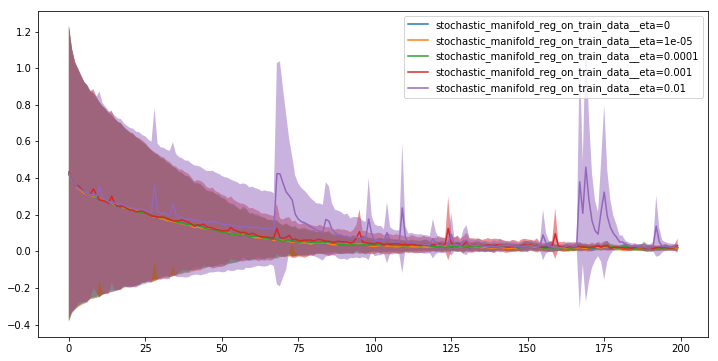

In [33]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(train_losses[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        train_losses[mode].mean(axis=0) - train_losses[mode].std(axis=0),
        train_losses[mode].mean(axis=0) + train_losses[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

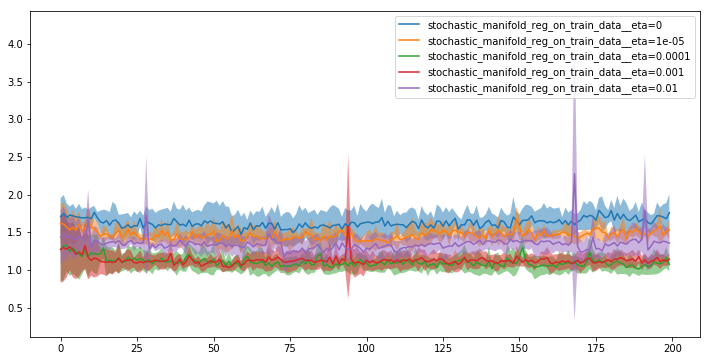

In [34]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(test_losses[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        test_losses[mode].mean(axis=0) - test_losses[mode].std(axis=0),
        test_losses[mode].mean(axis=0) + test_losses[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

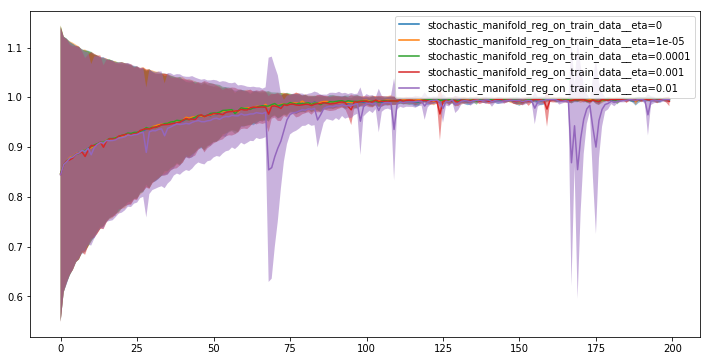

In [35]:
plt.figure(figsize=(12, 6))

for mode in modes:
    plt.plot(train_accs[mode].mean(axis=0))
    plt.fill_between(
        range(num_epochs),
        train_accs[mode].mean(axis=0) - train_accs[mode].std(axis=0),
        train_accs[mode].mean(axis=0) + train_accs[mode].std(axis=0),
        alpha=0.5
    )
plt.legend(modes)

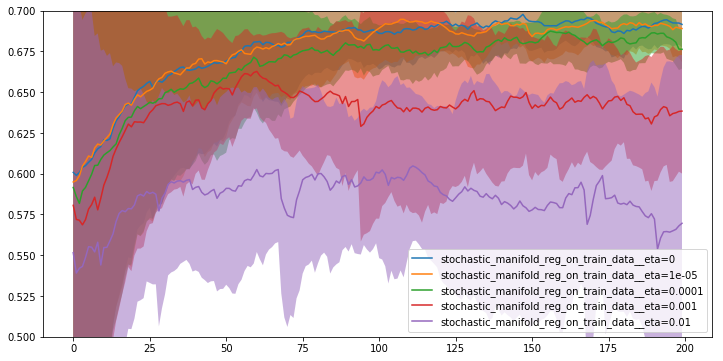

In [50]:
plt.figure(figsize=(12, 6))

alpha = 0.2
for mode in modes:
    curve = test_accs[mode]
    plt.plot(Series(curve.mean(axis=0)).ewm(alpha=alpha).mean())
    plt.fill_between(
        range(num_epochs),
        Series(curve.mean(axis=0) - curve.std(axis=0)).ewm(alpha=alpha).mean(),
        Series(curve.mean(axis=0) + curve.std(axis=0)).ewm(alpha=alpha).mean(),
        alpha=0.5
    )
plt.ylim(0.5, 0.7)
plt.legend(modes)

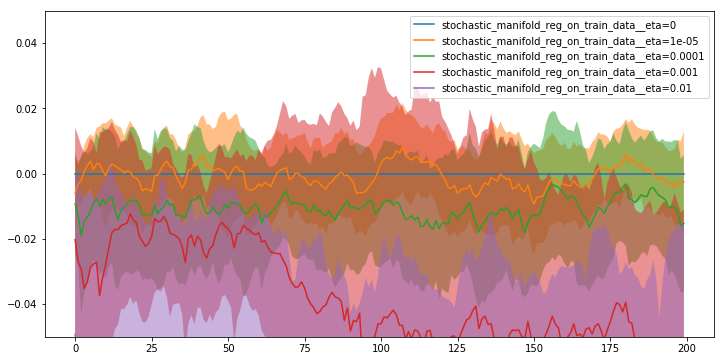

In [51]:
plt.figure(figsize=(12, 6))

alpha = 0.2
for mode in modes:
    curve = test_accs[mode] - test_accs[modes[0]]
    plt.plot(Series(curve.mean(axis=0)).ewm(alpha=alpha).mean())
    plt.fill_between(
        range(num_epochs),
        Series(curve.mean(axis=0) - curve.std(axis=0)).ewm(alpha=alpha).mean(),
        Series(curve.mean(axis=0) + curve.std(axis=0)).ewm(alpha=alpha).mean(),
        alpha=0.5
    )
plt.ylim(-0.05, 0.05)
plt.legend(modes)